# Fly Behavior Detection - Is a fly raised alone or with a group?


### Tamar Aranoff, Avi Attal and Asaf Feldman

### Overview and Motivation
Many species have adopted to living in groups. Living in a group takes different levels of complexity depends in the species. From very basic and random interactions to fully synchronized collective behavior. These interactions can be described and quantized by measuring different parameters of an individual and the individual interacting with others inside the group. It is assumed that when interacting with the group, previous experience, motivation, and psychological state are affected because of the other individuals inside the group giving rise to diverse activity levels, behavioral responses, and engagement with others.

A study done in the Life Sciences and Brain Research departments in Bar Ilan university, measured different interactions between flies. One group of flies was raised in isolation conditions with no interaction with other flies, while the other group was raised together. Then a total of 10 flies either from the isolated flies or grouped flies were put into a small container for the experiment. Using recording and tracking methods a set of parameters and features was generated for each fly in the experiment. Some examples of these parameters are velocity, angular direction, distance to other flies and more. These parameters are recorded and stored for each fly for the entire test and a data base of all the flies is available for analysis. 

This experiment can help quantize the effects of the way a fly is raised on its interaction with other flies in the group and on its behavior around other flies. We can analyze this data base to see which parameters are affected from the way the fly is raised and attempt to build a model which can determine whether a fly is raised in a group or in isolation based on its behavior. The first is important because it can help the researchers understand the most important features of the flies and eliminate noisy and unnecessary analysis. The later is even more important because maybe it can help build a detection model that can determine the psychological behavior of a random fly while interactiing in a group. 
  
 

### Related Work
This work is based on an experiment done in the Life Sciences and Brain Research departments in Bar Ilan university. The paper which explains the experiment is found here: https://doi.org/10.1016/j.cub.2020.10.060

We found this work to be interesting because it’s based on a real experiment with significant outcomes on social behavior. Also, the data was very raw and wasn’t in the right formats for the analysis we studied in the course. This required cleaning, organizing, and then analyzing it which we thought would contribute to the challenge. Finally, the all the data requires time series analysis because each fly is measured throughout  a movie which we thought would be interesting. 


## Initial Questions and Evolution of them during the project

Initially, there were two main questions we are trying to answer with this project:

1)	Can we build a model that can detect if a fly is growing in an isolated or non-isolated environment based on different parameters measured during its behavior?

2)	Why certain parameters express the experience of the individual over others? Meaning how will be able to explain and interpret the model.

After some basic statistical analysis and EDA, we saw that the model is not so interpretable, and which are significant parameters to look at. Also, the data base size is not so large as will be shown and it wasn’t quite balanced between the two groups. This led us to thinking of new ways to expand and balance our data base with methods like, random sampling and SMOTE. Finally, we tried to find out which parameters contribute the most to the decision of the model, learn them and think of explanations why they are the most relevant.


## Building and Understanding The Data Base

The data is comprised of movies that are taken at groups of 10 flies in a container. In each movie there are 10 flies that are all grown either in an isolated or a non-isolated environment. 
An example of such movies is presented below:



<video controls src="grouped movie.mp4" width="300" height="300" />

Using tracking techniques, a set of 66 parametrs is generated for each of the 10 flies per frame of the movie. We assume the each movie is indepedent of other movies and we expect similar behaviors of the flies mostly depedent on their exprience and not on a given movie or group of 10 flies. Thus, is it assumable to think that a each fly is an indpedant sample in the data regardless of the movie.

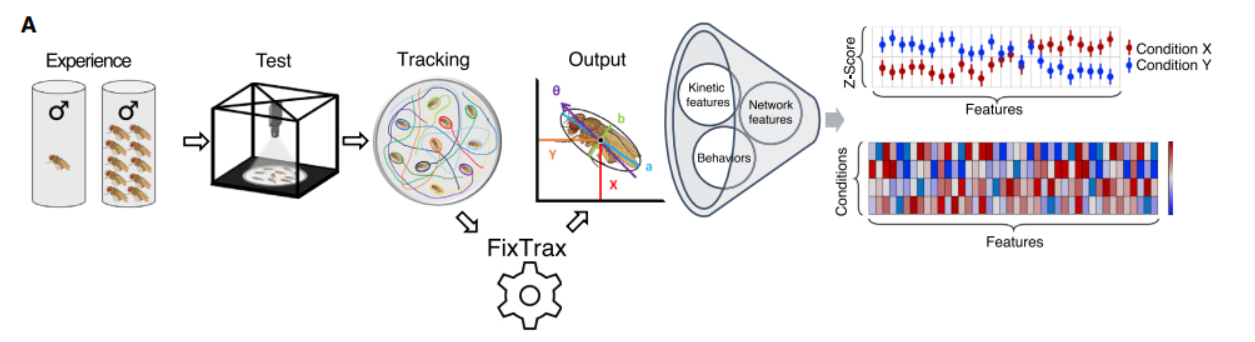

All the raw data came in .mat files which the researchers created after post-processing the videos.

The first step of building the data base, was transferring the .mat files into .csv files using a dedicated script (script is available in our folder if needed). Then a CSV file per parameter is generated for all the flies in either the grouped or isolated flies. Based on these files we ran the EDA and built our models.

First We import all th packages we will need for the EDA and understanding the data and other packages we will use in the project

In [1]:
#To run:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import glob 
import numpy as np
import seaborn as sns
import warnings
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

#ignore warnings - this is only a school project :)
import warnings
warnings.filterwarnings('ignore')

Then we created a CSV with all the parameters of the flies with their description

In [5]:
#To run:
param_init_file = "param_init.csv"
param_table = pd.read_csv(param_init_file)  
#result_dir_name = "eda_avi_1/"

#param_table_en = param_table[param_table['Enabled'] == 1]
param_list = param_table["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
param_table_flat = param_table.drop(['Enabled','Sig'],axis=1)
param_table_flat["Param"] = param_table["Param"].map(lambda x: x.lstrip("'").rstrip("''"))

In [3]:
param_table_flat

Param  \
0                        a_mm   
1   absanglefrom1to2_nose2ell   
2                   absdtheta   
3                   absdv_cor   
4         absphidiff_anglesub   
..                        ...   
57                velmag_tail   
58         veltoward_anglesub   
59         veltoward_nose2ell   
60                        yaw   
61                     absyaw   

                                          Description  
0    Quarter major axis length (mm). This feature ...  
1   Absolute diﬀerence between direction to closes...  
2    Angular speed (rad/s) |dtheta|. Transformatio...  
3    Sideways speed of the animal’s center of rota...  
4    Absolute diﬀerence in velocity direction betw...  
..                                                ...  
57  Speed of the animal’s tail (mm/s). Transformat...  
58  Velocity of this animal in the direction towar...  
59   Velocity of this animal in the direction towa...  
60   Diﬀerence between velocity direction and orie...  
61  Absolute difference between velocity direction...  

[62 rows x 2 columns]

For example, lets choose the  parameter "decenter" and see what it means and then look at the raw data in its CSV file for the grouped flies

In [63]:
with pd.option_context('display.max_colwidth', 500):
    print("decnter description:")
    print(param_table_flat.loc[param_table_flat["Param"] == "dcenter"]["Description"])

decnter description:
28     Minimum distance from this animal’s center to other animal’s center. Transformations: none, relative. 
Name: Description, dtype: object


In order to be able to control which pramters we want in the EDA the full param init csv file has an enable field:

Now lets take a look at one of the raw paramter files for example "dcenter". We will look at the file that contains the flies the grew up in the group

In [65]:
#To run:
#choose the param you want
param_name='dcenter'
#choose group type isolated or grouped
group_type1='grouped'
group_type2='isolated'
param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

data_grouped = pd.read_csv(param_file_name_1)
data_isolated = pd.read_csv(param_file_name_2)

#num_of_frames = 26987
#fr = np.arange(num_of_frames)

In [5]:
data_grouped.head()

Unnamed: 0        param                                                dir  \
0           1  dcenter.mat  ./Assa_Males_Grouped_different_vials_Unknown_R...   
1           2  dcenter.mat  ./Assa_Males_Grouped_different_vials_Unknown_R...   
2           3  dcenter.mat  ./Assa_Males_Grouped_different_vials_Unknown_R...   
3           4  dcenter.mat  ./Assa_Males_Grouped_different_vials_Unknown_R...   
4           5  dcenter.mat  ./Assa_Males_Grouped_different_vials_Unknown_R...   

   fly         X1         X2         X3         X4         X5         X6  ...  \
0    1  79.105881  79.495270  79.848792  80.198306  80.921190  81.496145  ...   
1    2  38.129044  38.109907  37.801359  37.928374  37.692951  37.572097  ...   
2    3  25.807549  26.667341  27.247456  27.683046  28.171990  28.793995  ...   
3    4  25.807549  26.667341  27.247456  27.683046  28.171990  28.793995  ...   
4    5  38.129044  38.109907  37.801359  37.928374  37.692951  37.572097  ...   

      X26978     X26979     X26980     X26981     X26982     X26983  \
0  12.266620  12.270622  12.268923  12.269409  12.268496  12.269295   
1  38.448528  38.462534  38.467847  38.480644  38.465744  38.492805   
2  22.249093  22.142382  22.034124  21.864827  21.745274  21.588831   
3   4.305045   4.289503   4.276571   4.294484   4.314030   4.297175   
4   4.305045   4.289503   4.276571   4.294484   4.314030   4.297175   

      X26984     X26985     X26986     X26987  
0  12.269929  12.267486  12.271963  12.272512  
1  38.482657  38.476353  38.488754  38.474977  
2  21.551969  21.403224  21.238002  21.119620  
3   4.300501   4.287423   4.286996   4.270460  
4   4.300501   4.287423   4.286996   4.270460  

[5 rows x 26991 columns]

 So we can see the parameter name, then the "dir" field which is the moive name the fly number in the given movie which  and the parameter value in each of the movie frames
 
 

# EDA

## Time Series Visualization

Now we can plot the "dcenter" parameter vs. time (frame) for a few flies in a random moive to see maybe a behavior we woulod like to capture

Text(0.5, 1.0, 'Type: isolated')

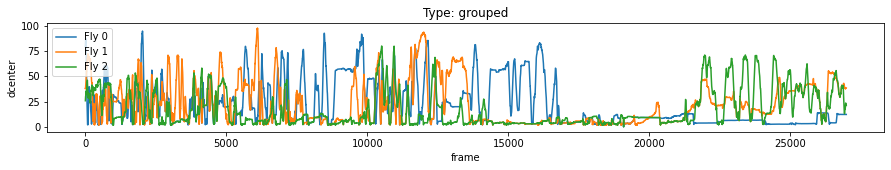

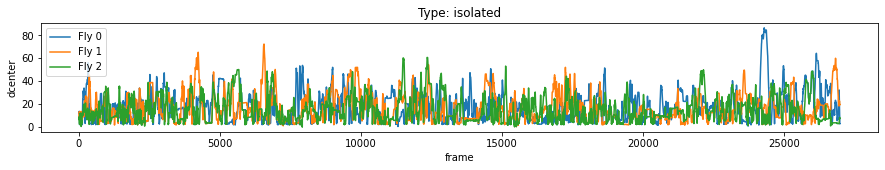

In [7]:
#choose the param you want
param_name='dcenter'
num_of_frames = 26987
fr = np.arange(num_of_frames)
num_of_flies = 3
#now randomly choose 5 movies and create 5 plots
#-------------
#grouped:
group_type = 'grouped'
data_grouped2 = data_grouped.iloc[0:num_of_flies,:]
#Clean unnecessary columns from the data frame
data_grouped_clean = data_grouped2.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
fig = plt.figure()
fig.set_size_inches(15, 2)
for f in np.arange(num_of_flies):
    #data_grouped_clean = data_grouped2.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
    #fly1 = grp_mov_1.drop([], axis=1)
    plt.plot(fr,data_grouped_clean.iloc[f],label='Fly {fly_num}'.format(fly_num=f))
plt.legend()    
plt.xlabel('frame')
plt.ylabel(param_name)
plt.title("Type: "+group_type)
          #+"\n Parameter: "+param_name+"\n Movie Name: "+movie)


    #---------------
#isolated:
group_type = 'isolated'
data_isolated2 = data_isolated.iloc[0:num_of_flies,:]
data_isolated_clean = data_isolated2.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
fig2 = plt.figure()
fig2.set_size_inches(15, 2)
for f in np.arange(num_of_flies):
    #fly1 = grp_mov_1.drop([], axis=1)
    plt.plot(fr,data_isolated_clean.iloc[f],label='Fly {fly_num}'.format(fly_num=f))
plt.legend()    
plt.xlabel('frame')
plt.ylabel(param_name)
plt.title("Type: "+group_type)
          #+"\n Parameter: "+param_name+"\n Movie Name: "+movie)


So maybe this is intresting and maybe will be something we would like to explore in the EDA part. In the grouped flies frequency that dcenter paramters is changing is much less the the isolated ones - perhaps this is a behavior we would like to try and capture with our model.

And intresting point here is that the data is very noise and perhaps its better to look at it with a moving average - we did this in the next section



Because this data is recorded over time we checked out some time series analysis tools which we found here:

https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775



In [66]:
#init the parameters you want from the init file 
param_init_file = "param_init.csv"
param_table = pd.read_csv(param_init_file)  
#result_dir_name = "eda_avi_1/"

param_table_en = param_table[param_table['Enabled'] == 1]
param_list = param_table_en["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
param_des = param_table["Description"].map(lambda x: x.lstrip("'").rstrip("''"))

num_of_frames = 26987
fr = np.arange(num_of_frames)

group_type1='grouped'
group_type2='isolated'

#Moving average window
window=5000

#Num of flies
num_of_flies = 4

#Num of params
n_param = len(param_list)

The Results off this are all the figures which we looked at are attached to the project folder


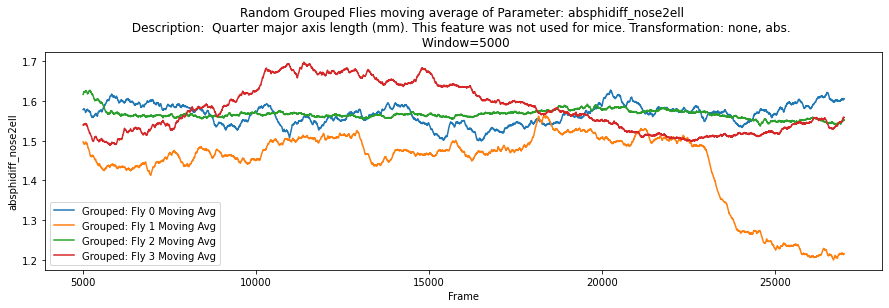

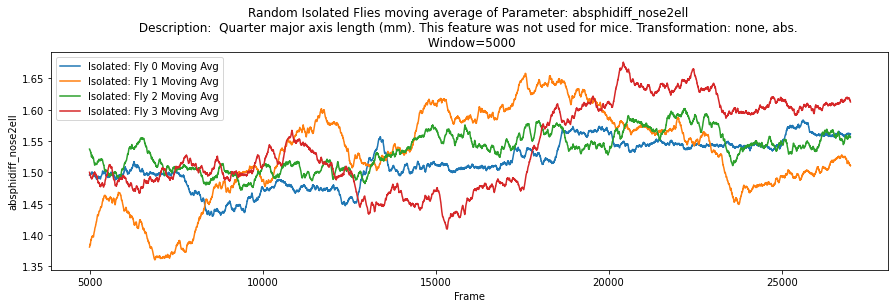

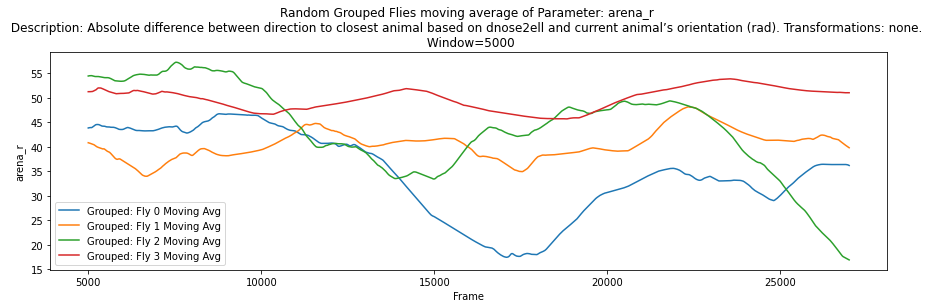

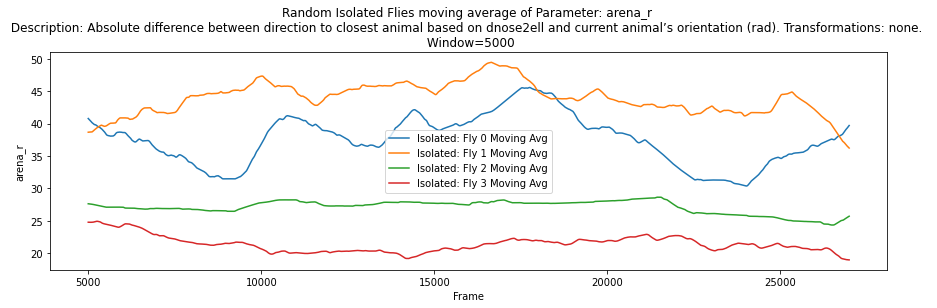

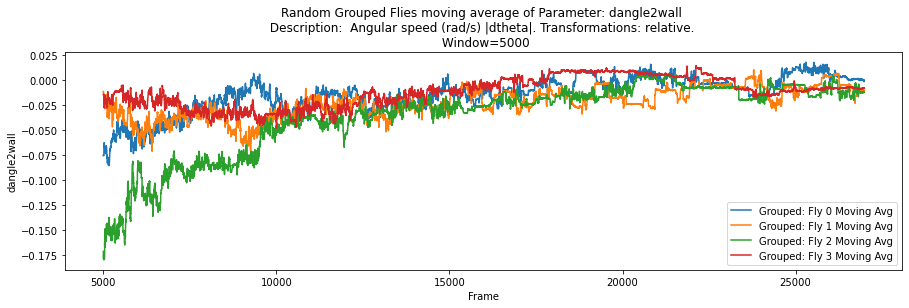

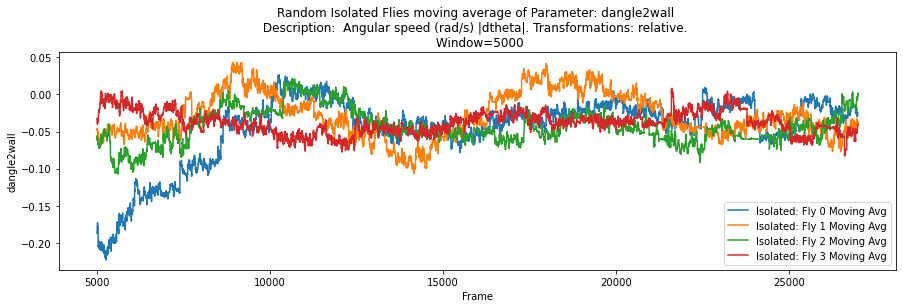

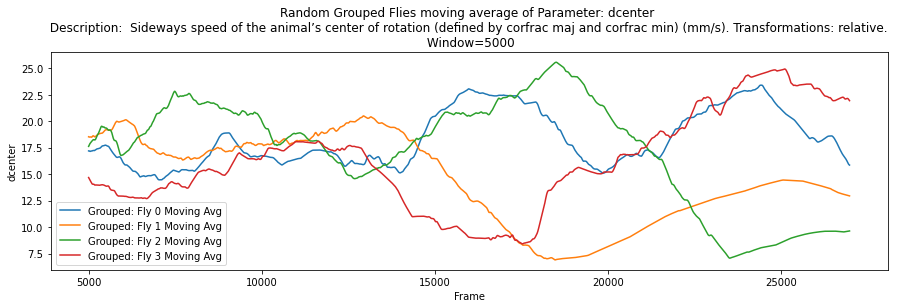

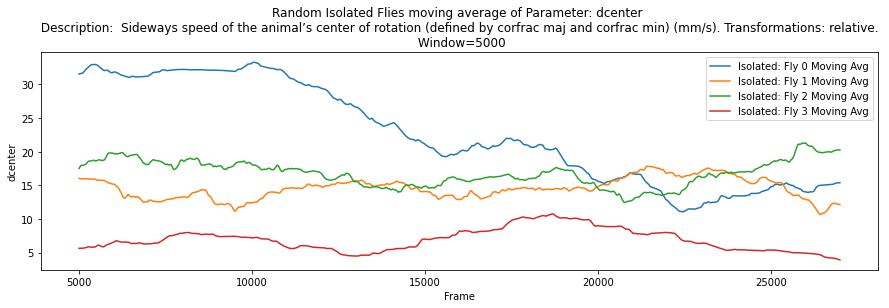

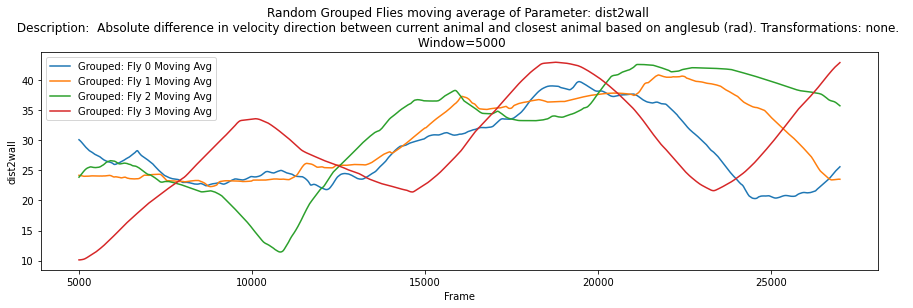

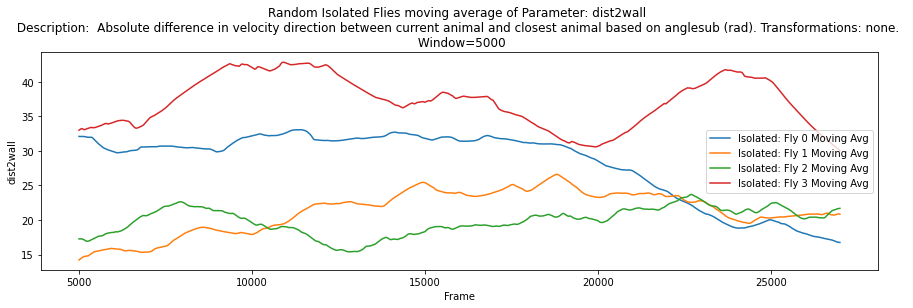

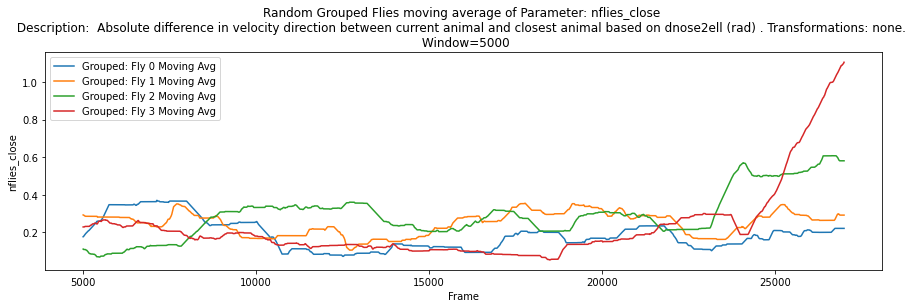

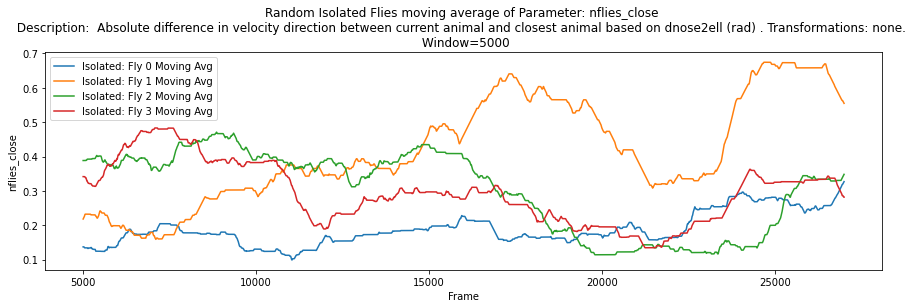

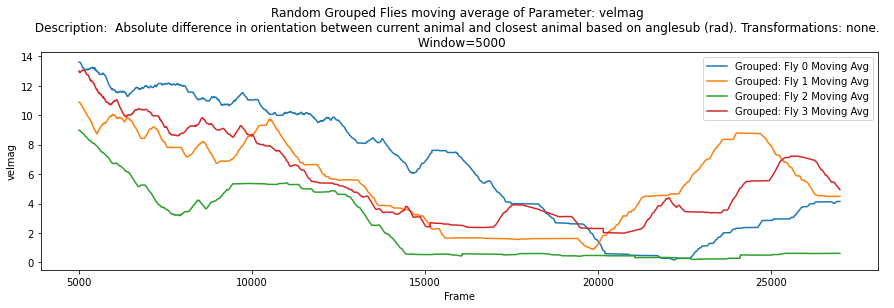

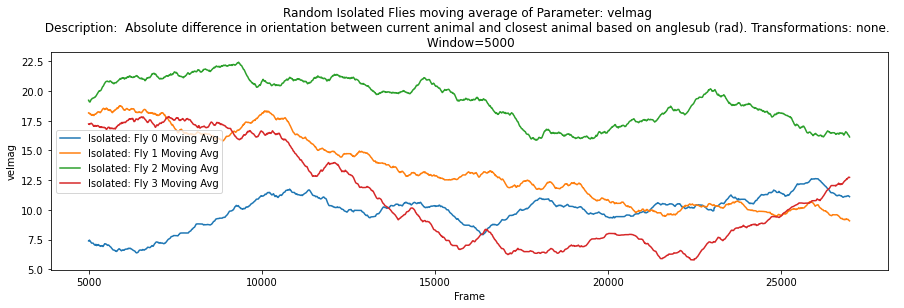

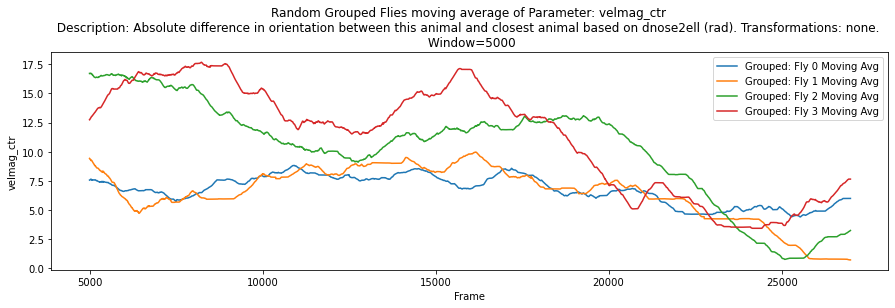

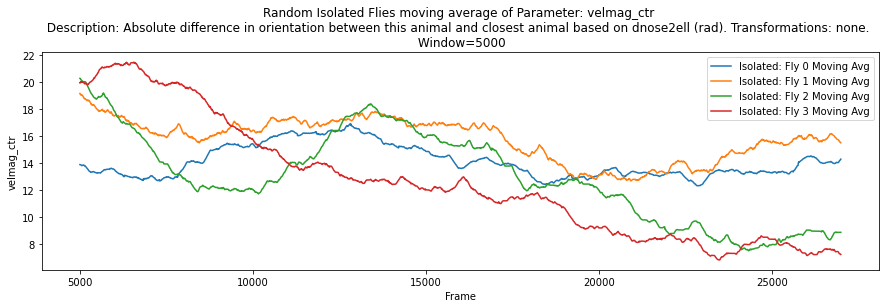

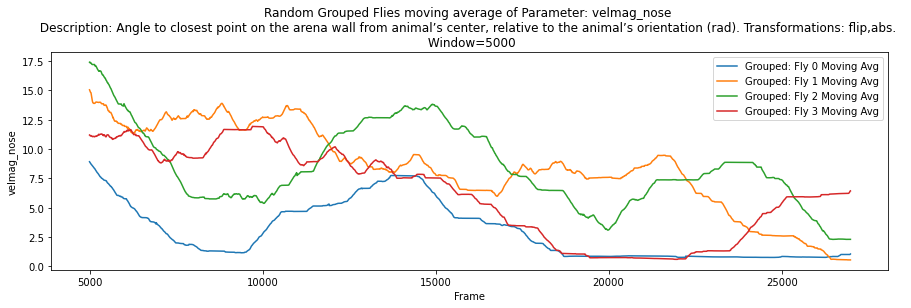

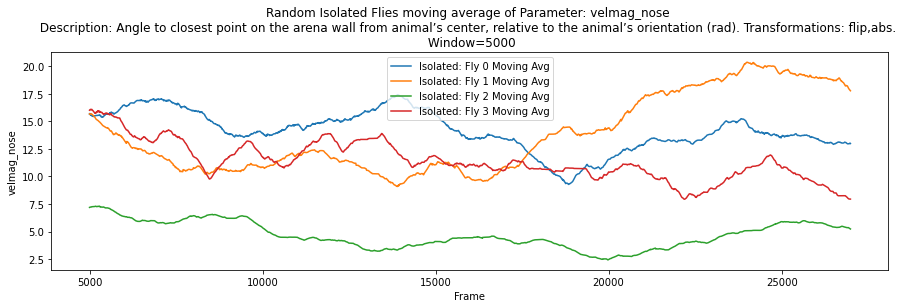

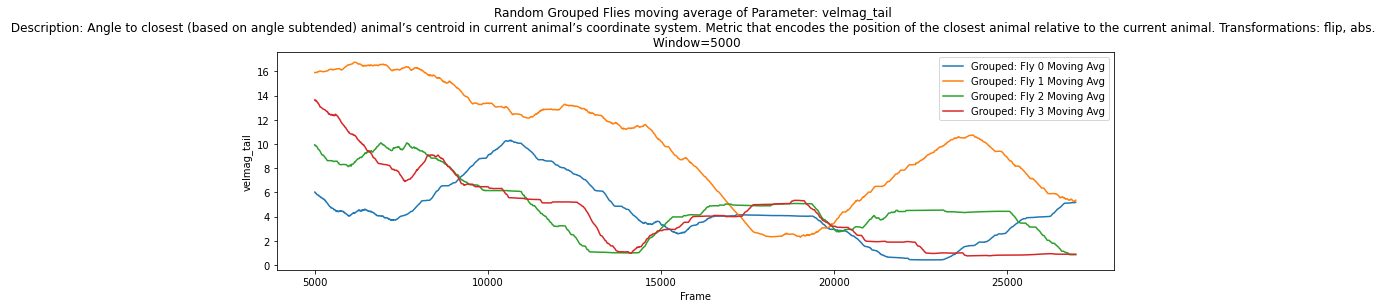

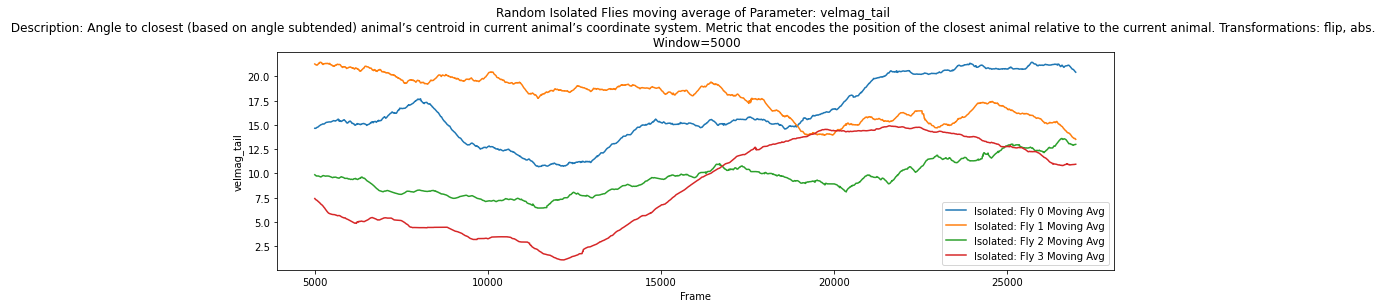

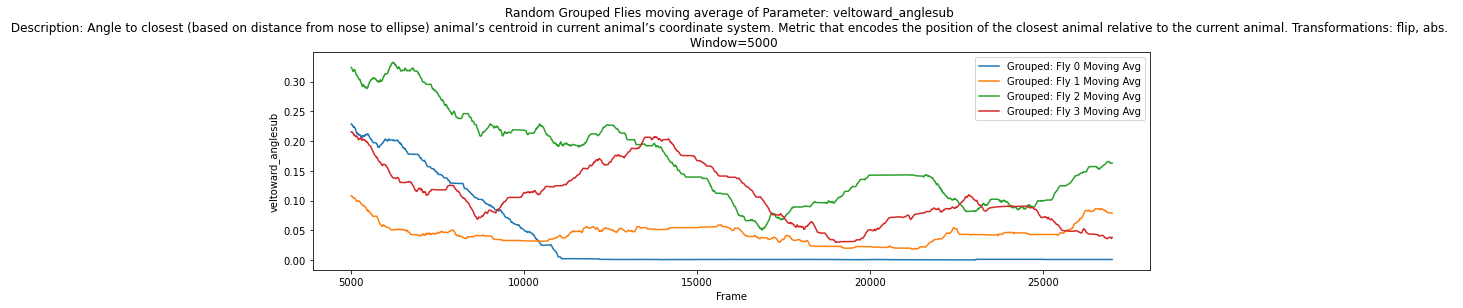

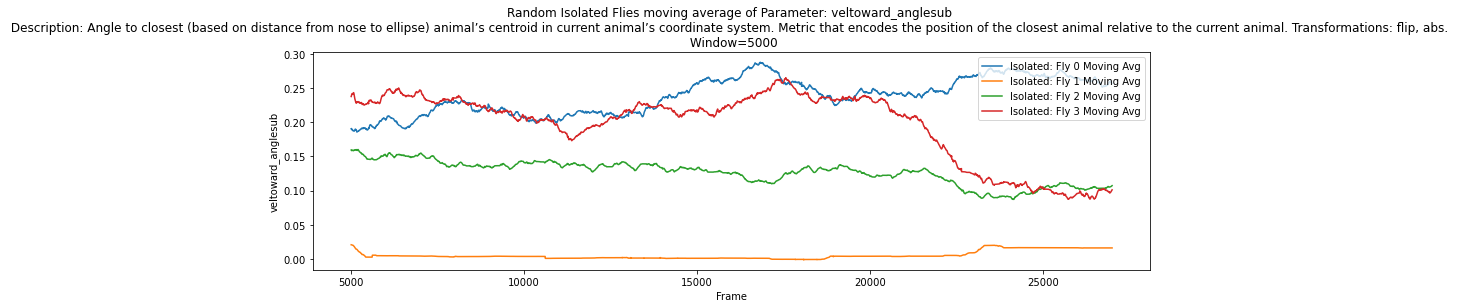

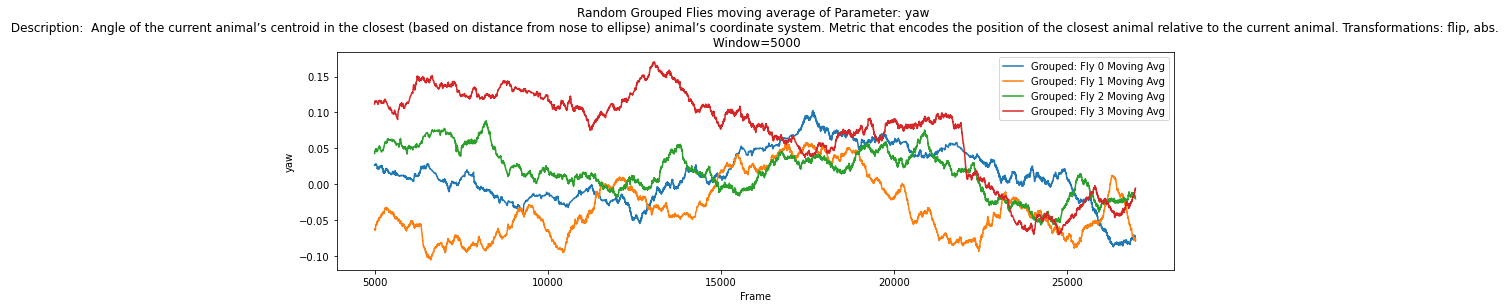

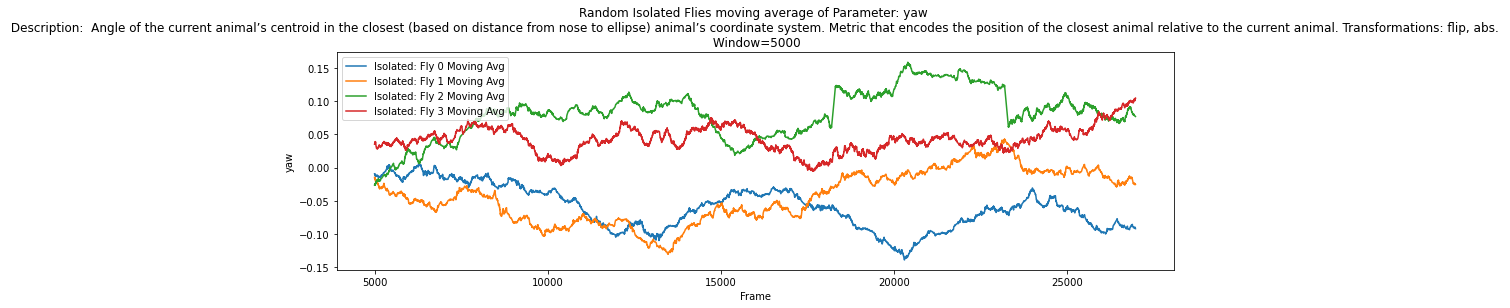

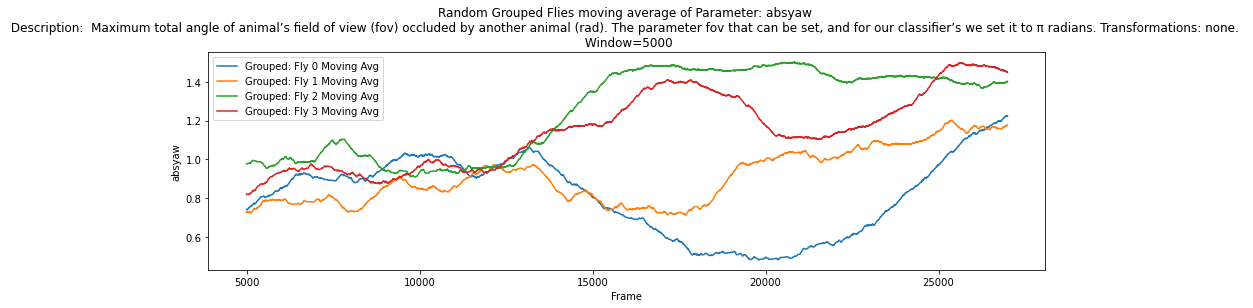

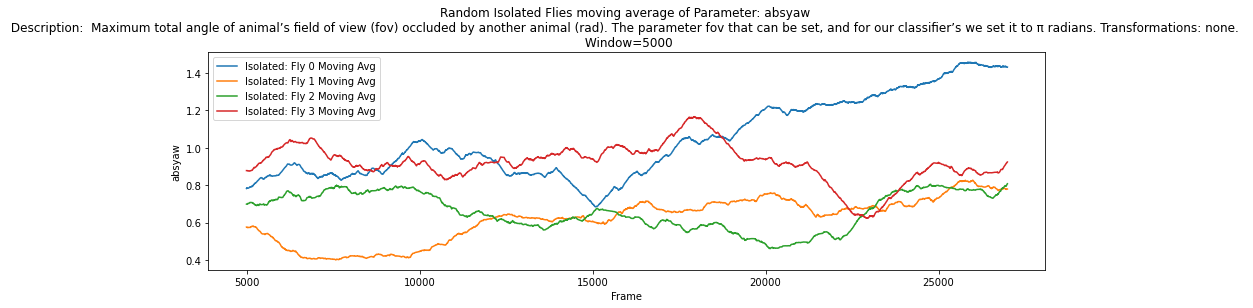

In [60]:
for p in np.arange(n_param):
    param_name = param_list.iloc[p]
    desc = param_des.iloc[p]
    #choose group type isolated or grouped
    param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
    param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

    data_grouped = pd.read_csv(param_file_name_1)
    data_isolated = pd.read_csv(param_file_name_2)
    #Drop un needed columns for the calculation
    data_grouped.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    data_isolated.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    random_flies_grp = data_grouped.sample(n=num_of_flies)
    random_flies_iso = data_isolated.sample(n=num_of_flies)
    

    fig2 = plt.figure()
    fig2.set_size_inches(15, 4)
    for f in np.arange(num_of_flies):
        rol_mean_grp = random_flies_grp.iloc[f].rolling(window=window).mean()
        plt.plot(fr,rol_mean_grp,label='Grouped: Fly {fly_num} Moving Avg'.format(fly_num=f))
    plt.title('Random Grouped Flies moving average of Parameter: {par} \n Description: {des} \n Window={window}'.format(window=window,par=param_name,des=desc))
    plt.ylabel(param_name)
    plt.xlabel('Frame')
    plt.grid(False)
    plt.legend()   
    plt.show()
    
    fig3 = plt.figure()
    fig3.set_size_inches(15, 4)
    for f in np.arange(num_of_flies):
        rol_mean_iso = random_flies_iso.iloc[f].rolling(window=window).mean()
        plt.plot(fr,rol_mean_iso,label='Isolated: Fly {fly_num} Moving Avg'.format(fly_num=f))
    plt.title('Random Isolated Flies moving average of Parameter: {par} \n Description: {des} \n Window={window}'.format(window=window,par=param_name,des=desc))
    plt.ylabel(param_name)
    plt.xlabel('Frame')
    plt.grid(False)
    plt.legend()   
    plt.show()

We can see some interesting behavior of the the grouped flies versus the isolated ones. 
For example the dist2wall parameter is increasing for the grouped flies (meaning they come closer to the center) whereas the isolated group it decreases and settle at a lower value indicating that maybe isolated flies want to be more by themselves and go closer to the wall 

### Further EDA , Statistical and Time Series Analysis
Another Idea we had is to take a significant anmount of flies like 100, and average a certain parameter per each frame and see if the group its self on an average has different behaviors

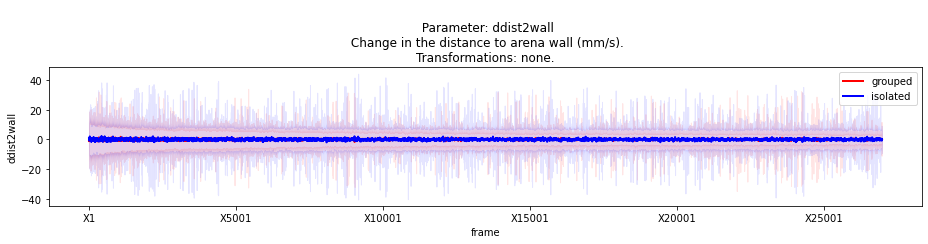

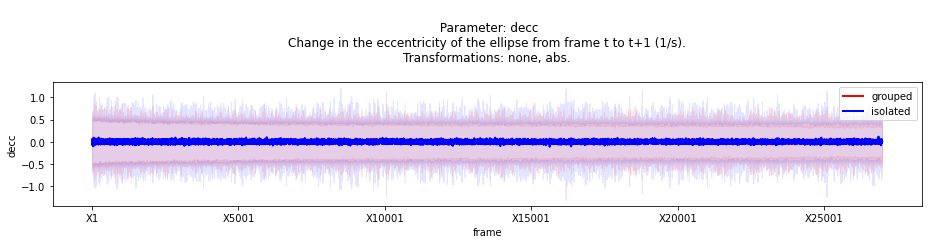

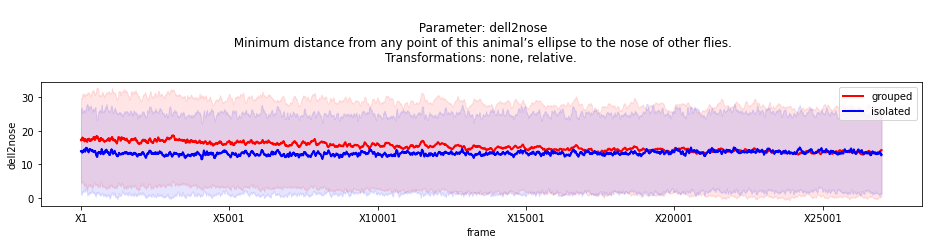

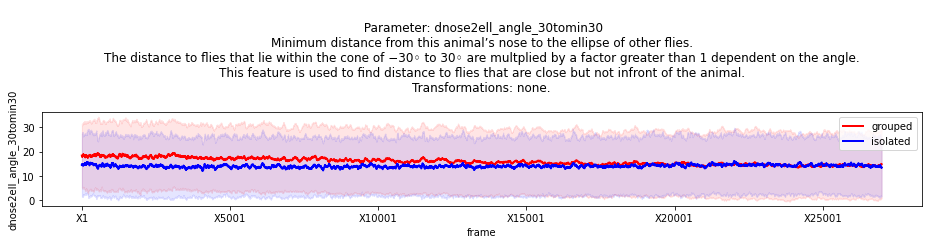

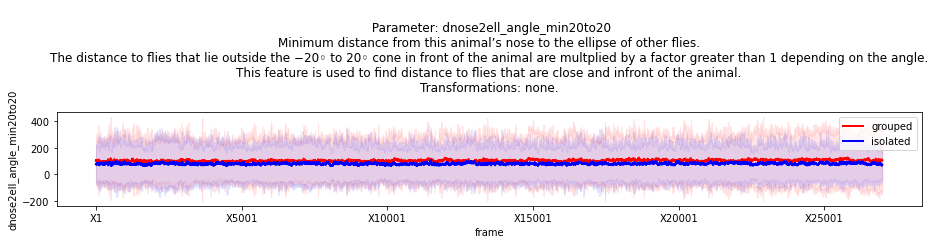

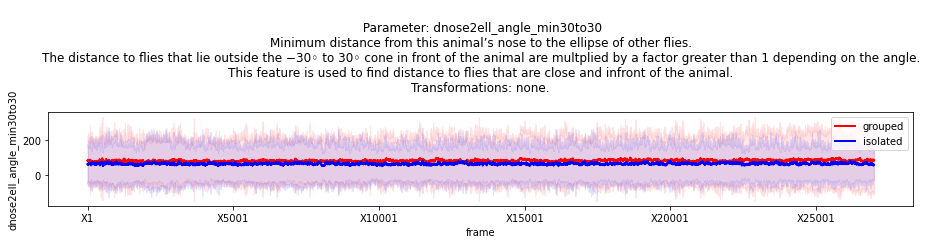

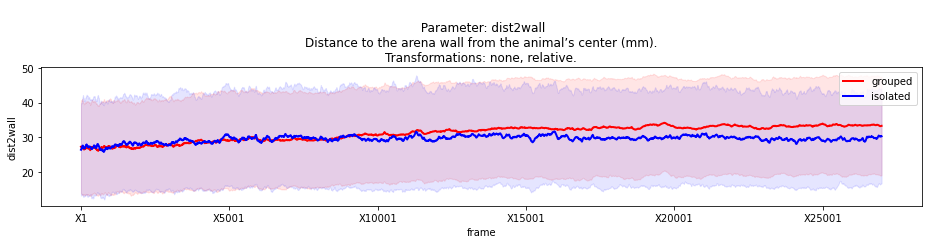

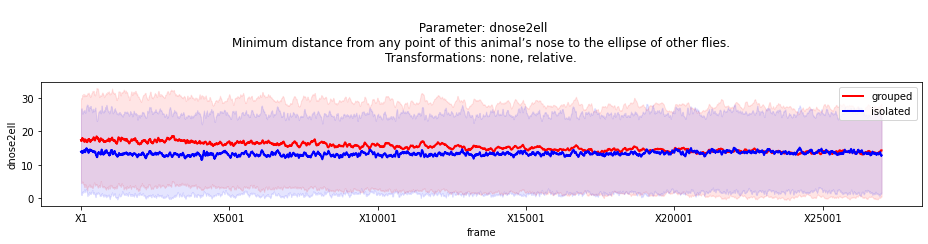

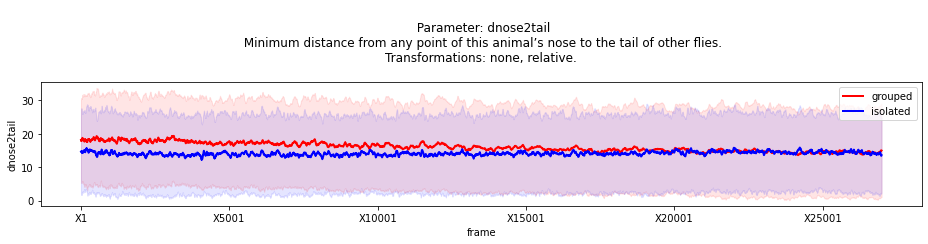

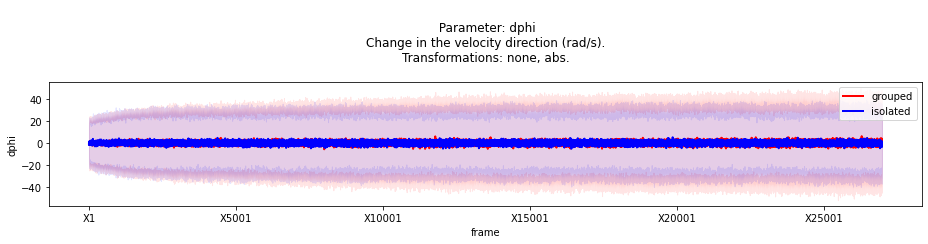

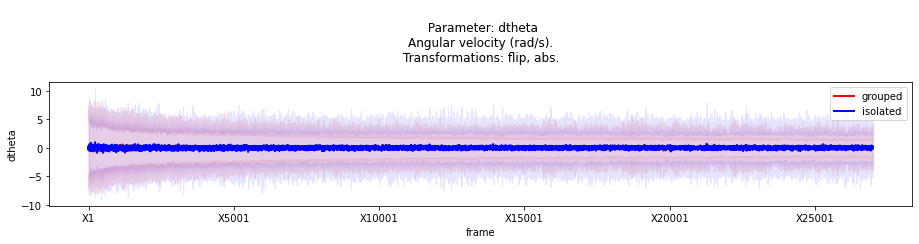

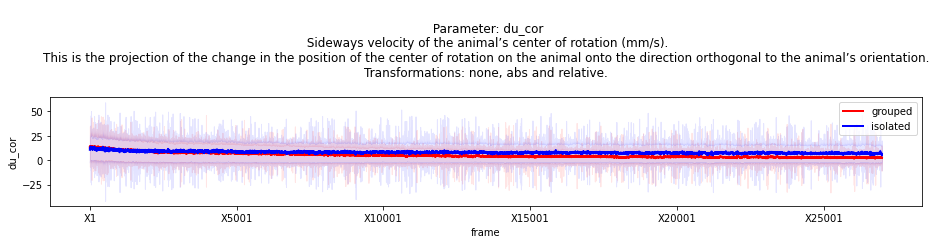

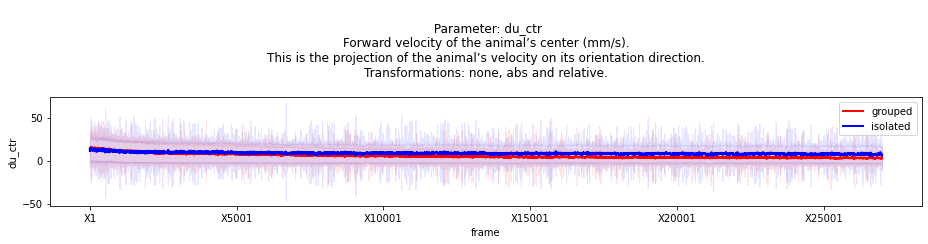

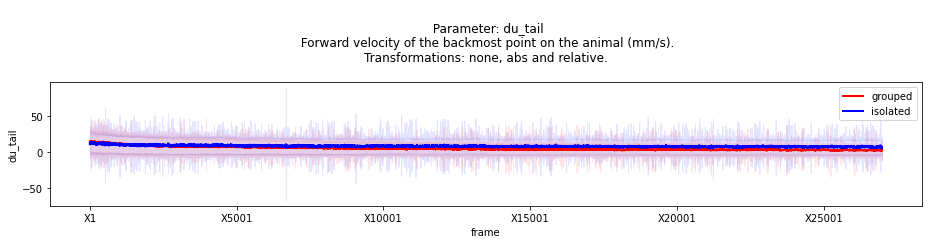

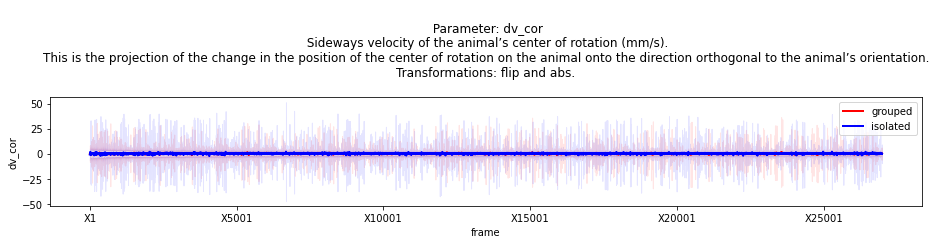

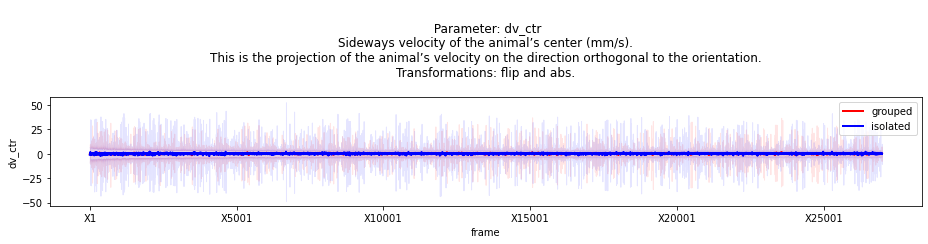

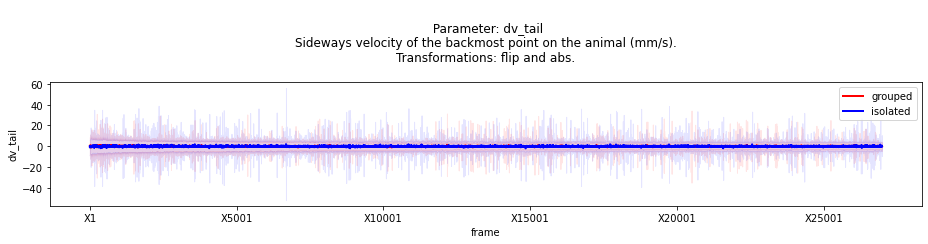

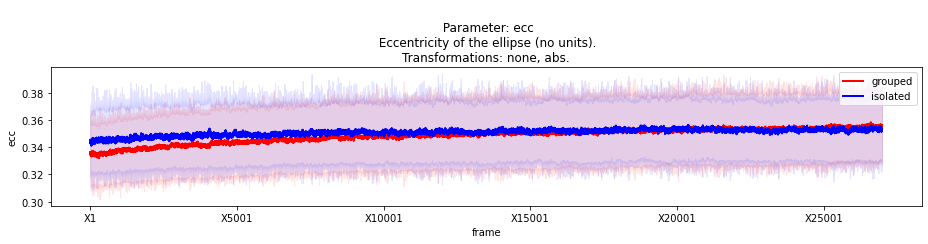

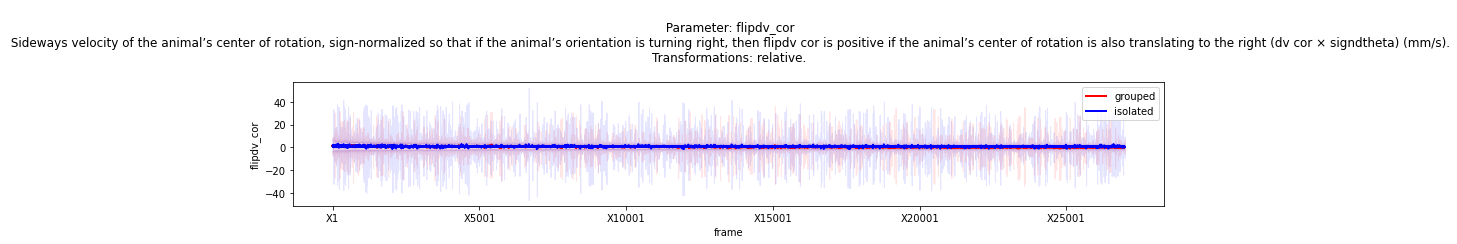

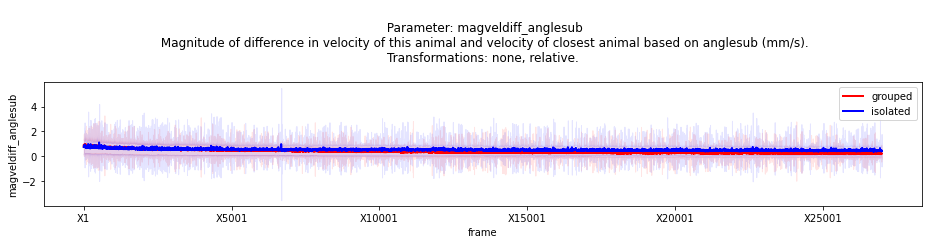

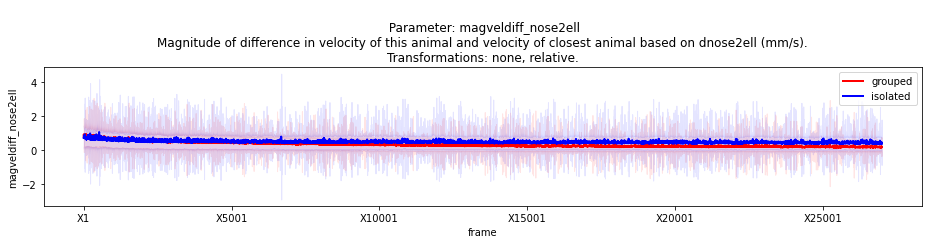

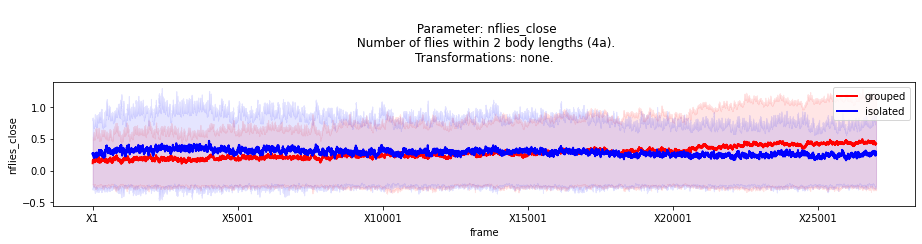

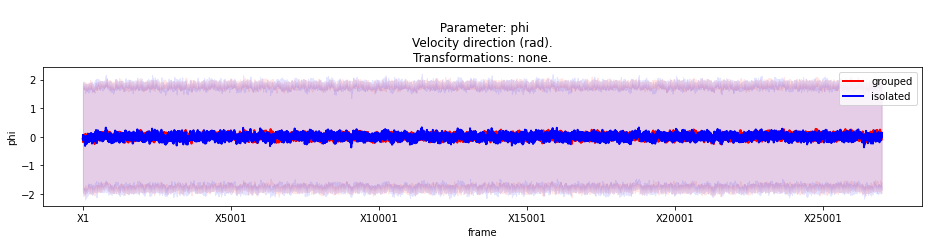

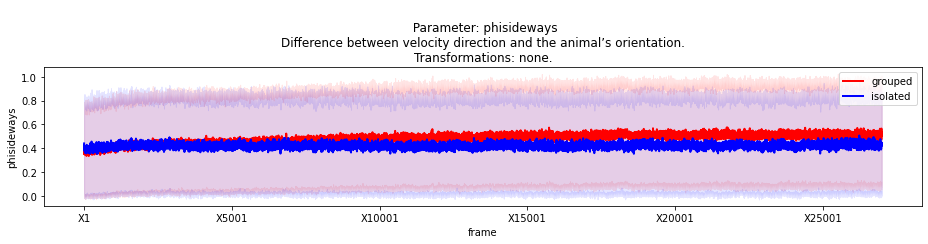

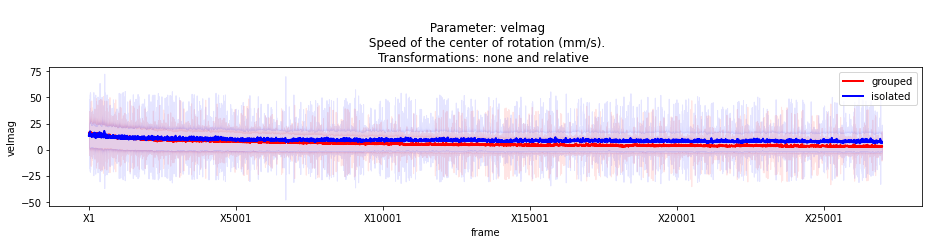

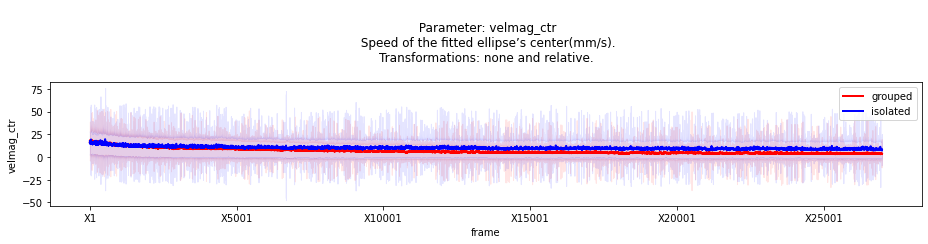

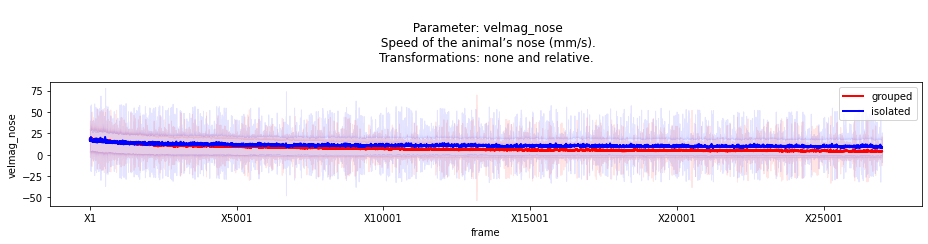

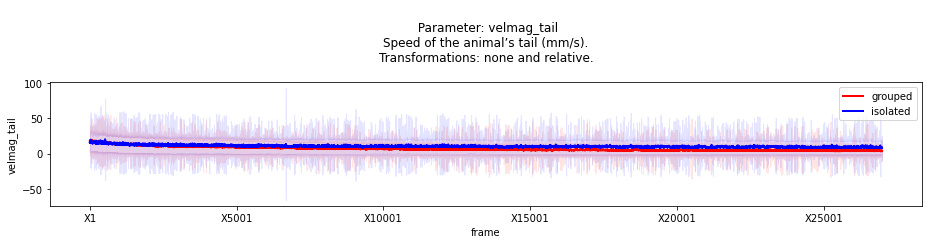

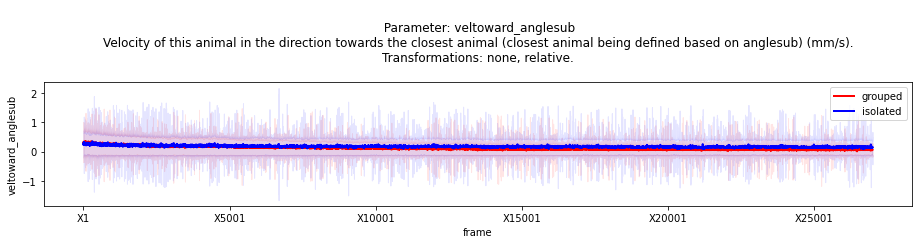

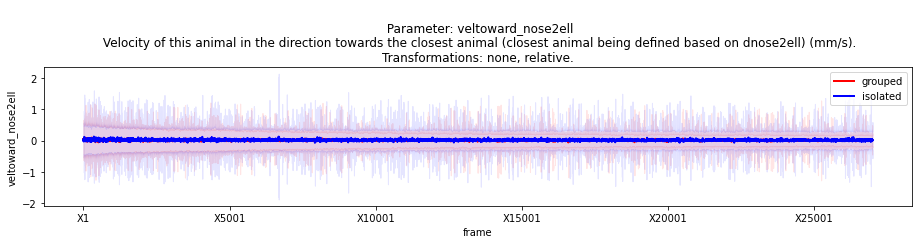

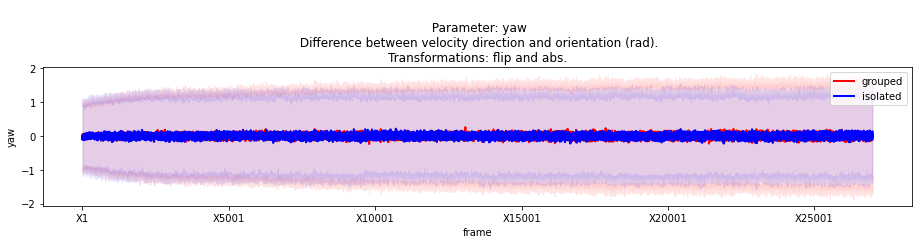

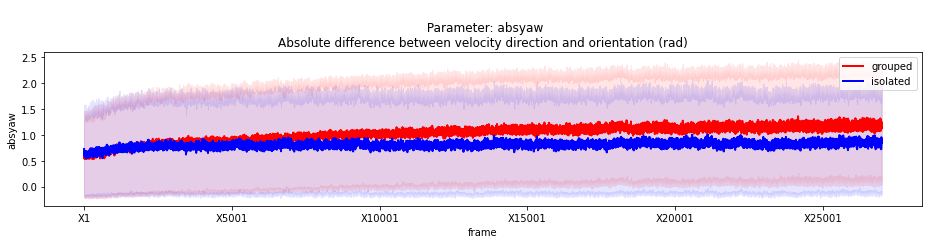

In [6]:
param_list = param_table["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
param_des = param_table["Description"].map(lambda x: x.lstrip("'").rstrip("''"))
#param_list = ['ddcenter','dcenter']
group_type1='grouped'
group_type2='isolated'
n_flies = 100
num_of_frames = 26987
fr = np.arange(num_of_frames)
for i in np.arange(30,len(param_list)):
    #------grouped-------
    param_name = param_list.iloc[i]
    des = param_des.iloc[i]
    group_type ='grouped'
    param_file_name="{grp_dir}/{par_name}.csv".format(grp_dir=group_type,par_name = param_name)
    data = pd.read_csv(param_file_name)
    data = data.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
    data = data.iloc[train_grouped_i]
    data_mean = np.mean(data.iloc[:,0:num_of_frames],axis=0)
    data_std = np.std(data.iloc[:,0:num_of_frames],axis=0)
    data_std
    
    plt.rcParams["figure.figsize"] = [13, 3.50]
    plt.rcParams["figure.autolayout"] = True

    line = data_mean
    line_deviation = data_std
    under_line = (line - line_deviation)
    over_line = (line + line_deviation)
    plt.plot(fr, line, linewidth=2, label='grouped',color='red')
    plt.fill_between(line_deviation.index, under_line,
                      over_line, color='red', alpha=.1)    
    #------isolated-------
    group_type='isolated'
    param_file_name="{grp_dir}/{par_name}.csv".format(grp_dir=group_type,par_name = param_name)
    data = pd.read_csv(param_file_name)
    #data = pd.read_csv(param_file_name)
    #movie_groups = data.groupby("dir")
    data = data.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
    data = data.iloc[train_isolated_i]
    data_mean = np.mean(data.iloc[:,0:num_of_frames],axis=0)
    data_std = np.std(data.iloc[:,0:num_of_frames],axis=0)
    data_std
    
    line = data_mean
    line_deviation = data_std
    under_line = (line - line_deviation)
    over_line = (line + line_deviation)
    plt.plot(fr, line, linewidth=2, label='isolated', color='blue')
    plt.fill_between(line_deviation.index, under_line,
                      over_line, color='blue', alpha=.1)
        
    plt.legend()    
    plt.xlabel('frame')
    plt.ylabel(param_name)
    des = des.replace(". ",".\n")
    plt.title("\n Parameter: "+param_name+'\n'+des)
              #+"\n Parameter: "+param_name+"\n Movie Name: "+movie)
    plt.xticks(np.arange(0, max(fr), 5000))
    #plt.axis((0,max(fr),np.mean([min(line),min(under_line)]),np.mean([max(line),max(over_line)])))
    plt.show()

After we saw that this shows better sepration between the groups - letting an average of a 100 flies develop over time - we decided to do the same for a smoother data. We used a movving average of each flies and then took a look at the average of 100 flies per fram

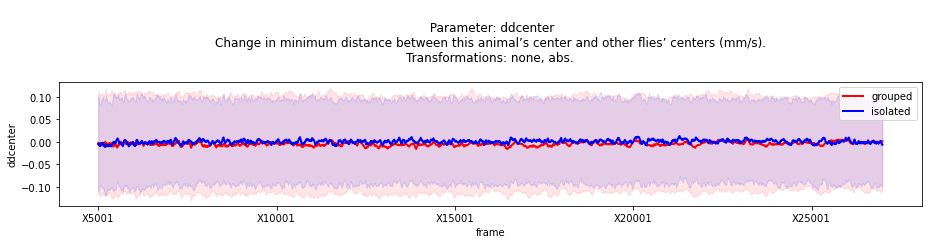

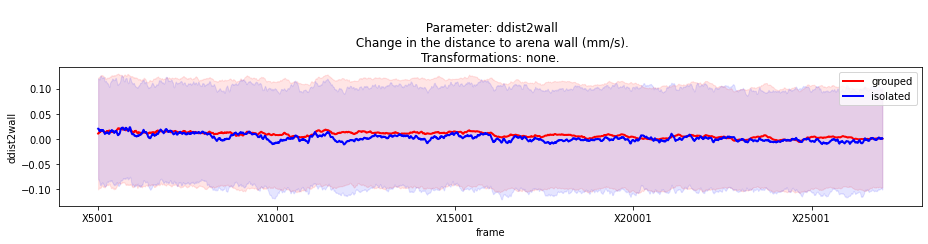

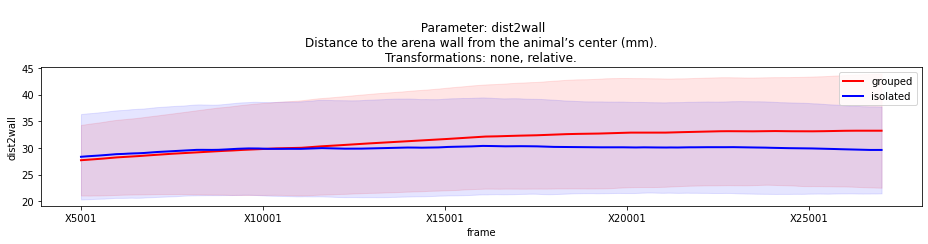

KeyboardInterrupt: 

In [6]:
#Moving average window
window=5000
#Take only the enabled parameters we want in the EDA
param_table_en = param_table[param_table['Enabled'] == 1]

param_list = param_table_en["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
param_des = param_table_en["Description"].map(lambda x: x.lstrip("'").rstrip("''"))
#param_list = ['ddcenter','dcenter']
n_flies = 100
num_of_frames = 26987
fr = np.arange(num_of_frames)
#n_param = len(param_list)
#n_param = [10,20]
for i in np.arange(0,len(param_list)):
    #------grouped-------
    param_name = param_list.iloc[i]
    des = param_des.iloc[i]
    param_file_name="{grp_dir}/{par_name}.csv".format(grp_dir='grouped',par_name = param_name)
    data = pd.read_csv(param_file_name)
    data = data.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
    for i in range(len(data)):
        data.iloc[i] = data.iloc[i].rolling(window=window).mean()
    data_mean = np.mean(data.iloc[:,0:num_of_frames],axis=0)
    data_std = np.std(data.iloc[:,0:num_of_frames],axis=0)

    plt.rcParams["figure.figsize"] = [13, 3.50]
    plt.rcParams["figure.autolayout"] = True

    line = data_mean
    line_deviation = data_std
    under_line = (line - line_deviation)
    over_line = (line + line_deviation)
    plt.plot(fr, line, linewidth=2, label='grouped',color='red')
    plt.fill_between(line_deviation.index, under_line,
                      over_line, color='red', alpha=.1)    
    #------isolated-------
    param_file_name="{grp_dir}/{par_name}.csv".format(grp_dir='isolated',par_name = param_name)
    data = pd.read_csv(param_file_name)
    data = data.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1)
    for i in range(len(data)):
        data.iloc[i] = data.iloc[i].rolling(window=window).mean()
    data_mean = np.mean(data.iloc[:,0:num_of_frames],axis=0)
    data_std = np.std(data.iloc[:,0:num_of_frames],axis=0)

    line = data_mean
    line_deviation = data_std
    under_line = (line - line_deviation)
    over_line = (line + line_deviation)
    plt.plot(fr, line, linewidth=2, label='isolated', color='blue')
    plt.fill_between(line_deviation.index, under_line,
                      over_line, color='blue', alpha=.1)
        
    plt.legend()    
    plt.xlabel('frame')
    plt.ylabel(param_name)
    des = des.replace(". ",".\n")
    plt.title("\n Parameter: "+param_name+'\n'+des)
              #+"\n Parameter: "+param_name+"\n Movie Name: "+movie)
    plt.xticks(np.arange(window, max(fr), 5000))
    #plt.axis((0,max(fr),np.mean([min(line),min(under_line)]),np.mean([max(line),max(over_line)])))
    plt.show()

# Trying to extract analytically which parameters are important 

We would like to see which paramters help capture different behaviors between the two groups and why. Becasue, there are many paramters and we were not sure which ones matter we first ran a basic analysis of looking at each fly in each group and taking the mean,std,min and max value of the parameter of each movie and creating histograms of the two groups

In [7]:
#grab param init file 
param_init_file = "param_init.csv"
param_table = pd.read_csv(param_init_file)  
result_dir_name = "eda/"

#Generate a list of the fly params we want to run the EDA
param_table_en = param_table[param_table['Enabled'] == 1]
#param_list = param_table_en["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
param_list = ['absdv_cor','absyaw','magveldiff_nose2ell']
group_type1='grouped'
group_type2='isolated'

for p in param_list:
    param_name=p
    #choose group type isolated or grouped
    param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
    param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

    data_grouped = pd.read_csv(param_file_name_1)
    data_isolated = pd.read_csv(param_file_name_2)

    #Drop un needed columns for the calculation
    data_grouped.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    data_isolated.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)


    data_grouped['average'] = data_grouped.mean(numeric_only=True, axis=1)
    data_grouped['std'] = data_grouped.std(numeric_only=True, axis=1)
    data_grouped['max value'] = data_grouped.max(numeric_only=True, axis=1)
    data_grouped['min value'] = data_grouped.min(numeric_only=True, axis=1)

    data_isolated['average'] = data_isolated.mean(numeric_only=True, axis=1)
    data_isolated['std'] = data_isolated.std(numeric_only=True, axis=1)
    data_isolated['max value'] = data_isolated.max(numeric_only=True, axis=1)
    data_isolated['min value'] = data_isolated.min(numeric_only=True, axis=1)

    #Now Plot the disbirtuion o mean,std,mix max
    params = ['average','std','max value','min value']
    for p1 in params:
        fig = plt.figure()
        plt.style.use('ggplot')
        data_grouped[p1].plot.hist(alpha=0.5,bins=50,label='grouped')
        data_isolated[p1].plot.hist(alpha=0.5,bins=50,label='isolated')
        plt.legend()    
        plt.xlabel(p1)
        plt.title("Parameter: "+param_name+ " Measure: "+p1)
        fig.savefig(result_dir_name+param_name+"_"+p1+".png")
        plt.clf()
        plt.close()

KeyboardInterrupt: 

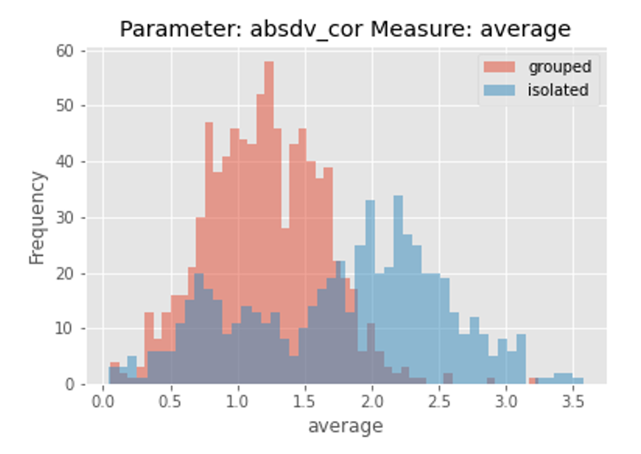
absdv_cor mean - Description:  Sideways speed of the animal’s center of rotation (deﬁned by corfrac maj and corfrac min) (mm/s). Transformations: relative.

1. Average side way speed of the grouped flies is lower and has a smaller std 
2. They move slower when looking to the side


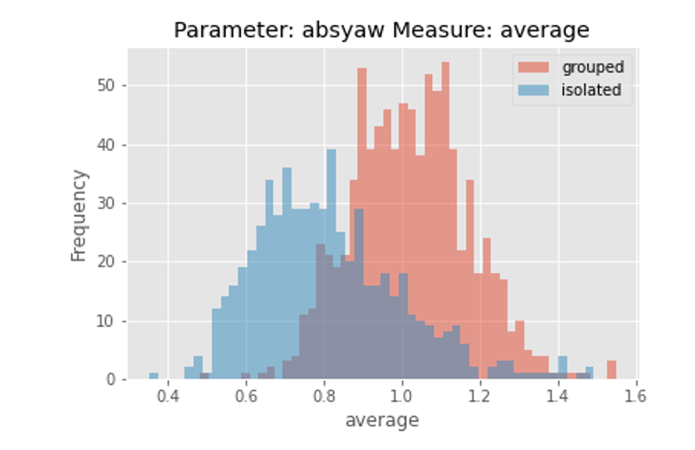
absyaw mean - Description:  Absolute difference between velocity directi on and orientation (rad) 

Seems like on average grouped flies are looking to the side when moving – maybe they are less afraid to see other flies?


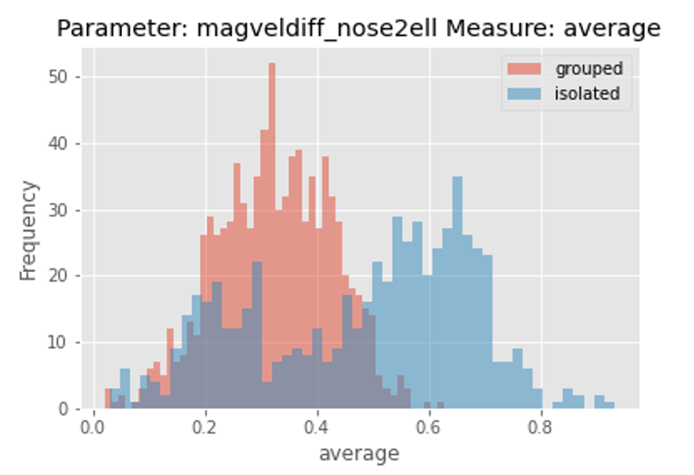
magveldiff_nose2cell mean - Magnitude of diﬀerence in velocity of this animal and velocity of closest animal based on dnose2ell (mm/s). Transformations: none, relative.

Seems like on average in the isolated group when 1 fly runs away the other ones stands still or maybe its hard for them to sync their movement



In this part, we analysed what are the features with the most difference between the both types.
We begin by normalizing the data and then grouping the features by type. 
The last step is measuring the means difference between the both types for each feature.

In [9]:
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

analysis_all_data = pd.read_excel('analysis_all_data.xlsx')
df = analysis_all_data.drop(columns=['Type'])
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=df.columns)
df['Class']='Grouped'
df[870:]['Class']='Isolated'
data_mean = df.groupby(['Class']).mean()
diff_mean = data_mean.loc['Grouped']-data_mean.loc['Isolated']
print(diff_mean.nlargest(30))

ddcenter_25%                      0.276356
absyaw_75%                        0.237057
danglesub_min                     0.207820
dv_cor_25%                        0.200752
dv_ctr_25%                        0.197905
dphi_std                          0.197317
ddist2wall_25%                    0.183207
dangle2wall_25%                   0.181837
area_min                          0.178735
dcenter_min                       0.178429
absyaw_mean                       0.178304
yaw_std                           0.172312
veltoward_nose2ell_25%            0.164404
absyaw_std                        0.163719
b_mm_min                          0.163135
a_mm_min                          0.161005
danglesub_25%                     0.158303
dv_tail_25%                       0.154797
dtheta_25%                        0.154394
Unnamed: 0                        0.150173
absanglefrom1to2_nose2ell_50%     0.127625
decc_min                          0.124586
dphi_75%                          0.124236
absyaw_50% 

In [10]:
selected_features = df[diff_mean.nlargest(30).index.to_series().tolist()]
selected_features['Class']='Grouped'
selected_features[870:]['Class']='Isolated'
selected_features.head()

ddcenter_25%  absyaw_75%  danglesub_min  dv_cor_25%  dv_ctr_25%  dphi_std  \
0      0.904080    0.631863       0.073860    0.970199    0.923623  0.617783   
1      0.833765    0.516278       0.562266    0.832460    0.725504  0.544567   
2      0.859483    0.627056       0.179129    0.923631    0.814654  0.639988   
3      0.948664    0.699279       0.626477    0.974786    0.921629  0.657053   
4      0.867106    0.623539       0.564916    0.960589    0.904113  0.573720   

   ddist2wall_25%  dangle2wall_25%  area_min  dcenter_min  ...  decc_min  \
0        0.952077         0.792723  0.068326     0.010810  ...  0.648257   
1        0.879309         0.610580  0.445472     0.716184  ...  0.793937   
2        0.898340         0.669723  0.732382     0.010810  ...  0.753819   
3        0.954681         0.823229  0.548979     0.699121  ...  0.864074   
4        0.926025         0.720439  0.829421     0.726790  ...  0.924326   

   dphi_75%  absyaw_50%  absanglefrom1to2_nose2ell_mean  corfrac_maj_mean  \
0  0.317879    0.334950                        0.500681          0.482733   
1  0.281883    0.344973                        0.485240          0.623017   
2  0.396645    0.422191                        0.527630          0.734099   
3  0.421130    0.455637                        0.750807          0.511499   
4  0.281032    0.336391                        0.535669          0.483933   

      a_min     b_min  corfrac_maj_50%  absanglefrom1to2_nose2ell_25%    Class  
0  0.000000  0.184980         0.597702                       0.398907  Grouped  
1  0.474498  0.837400         0.677515                       0.392689  Grouped  
2  0.546601  0.822623         0.792404                       0.471195  Grouped  
3  0.726803  0.784840         0.597702                       0.726858  Grouped  
4  0.856287  0.939063         0.519147                       0.378471  Grouped  

[5 rows x 31 columns]

In [11]:
selected_features[selected_features['Class']=='Grouped'].head()

ddcenter_25%  absyaw_75%  danglesub_min  dv_cor_25%  dv_ctr_25%  dphi_std  \
0      0.904080    0.631863       0.073860    0.970199    0.923623  0.617783   
1      0.833765    0.516278       0.562266    0.832460    0.725504  0.544567   
2      0.859483    0.627056       0.179129    0.923631    0.814654  0.639988   
3      0.948664    0.699279       0.626477    0.974786    0.921629  0.657053   
4      0.867106    0.623539       0.564916    0.960589    0.904113  0.573720   

   ddist2wall_25%  dangle2wall_25%  area_min  dcenter_min  ...  decc_min  \
0        0.952077         0.792723  0.068326     0.010810  ...  0.648257   
1        0.879309         0.610580  0.445472     0.716184  ...  0.793937   
2        0.898340         0.669723  0.732382     0.010810  ...  0.753819   
3        0.954681         0.823229  0.548979     0.699121  ...  0.864074   
4        0.926025         0.720439  0.829421     0.726790  ...  0.924326   

   dphi_75%  absyaw_50%  absanglefrom1to2_nose2ell_mean  corfrac_maj_mean  \
0  0.317879    0.334950                        0.500681          0.482733   
1  0.281883    0.344973                        0.485240          0.623017   
2  0.396645    0.422191                        0.527630          0.734099   
3  0.421130    0.455637                        0.750807          0.511499   
4  0.281032    0.336391                        0.535669          0.483933   

      a_min     b_min  corfrac_maj_50%  absanglefrom1to2_nose2ell_25%    Class  
0  0.000000  0.184980         0.597702                       0.398907  Grouped  
1  0.474498  0.837400         0.677515                       0.392689  Grouped  
2  0.546601  0.822623         0.792404                       0.471195  Grouped  
3  0.726803  0.784840         0.597702                       0.726858  Grouped  
4  0.856287  0.939063         0.519147                       0.378471  Grouped  

[5 rows x 31 columns]

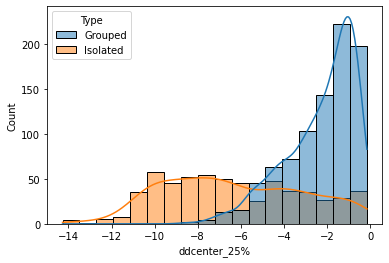

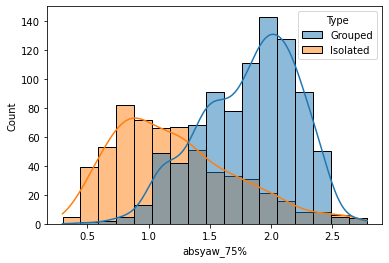

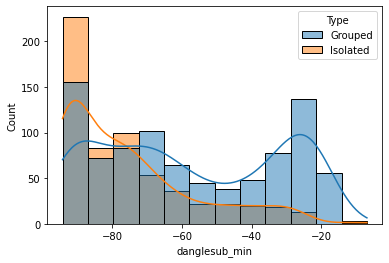

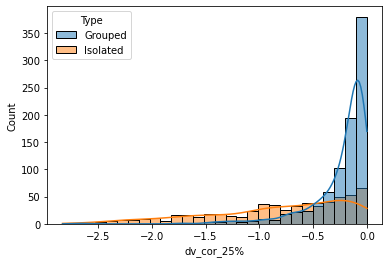

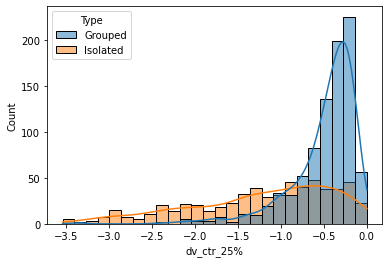

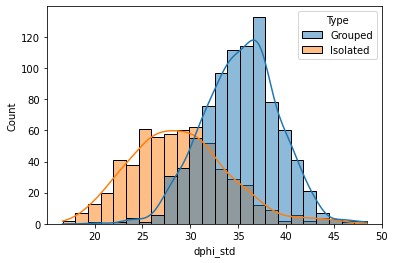

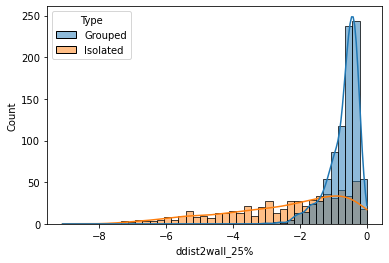

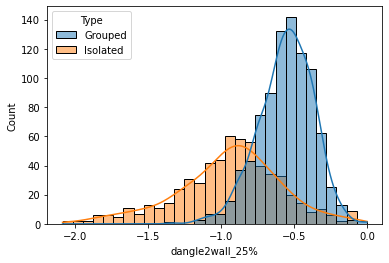

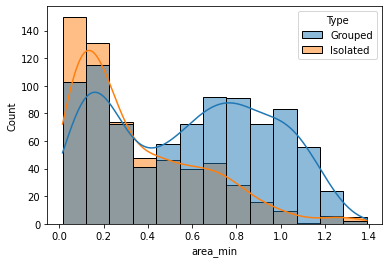

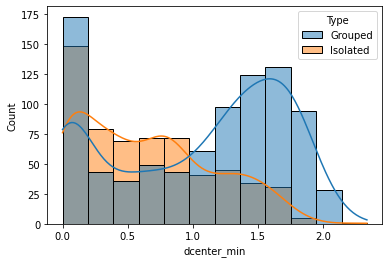

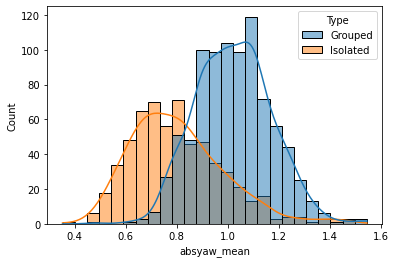

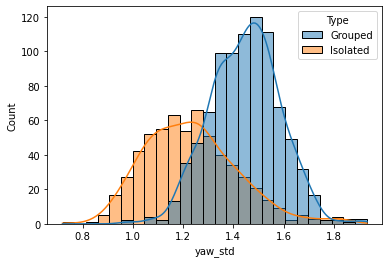

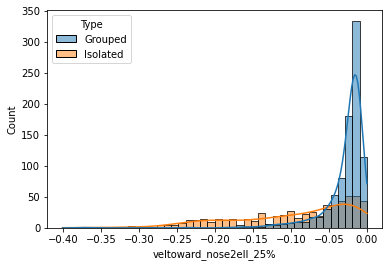

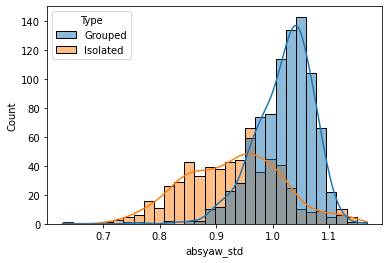

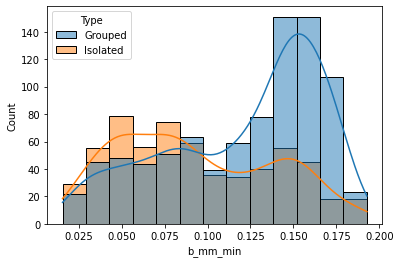

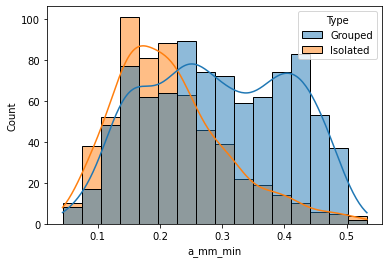

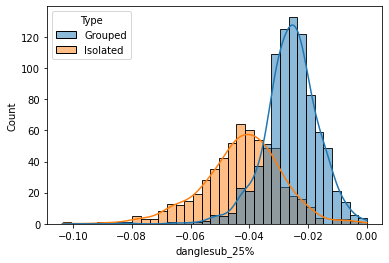

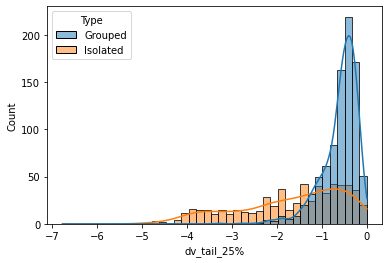

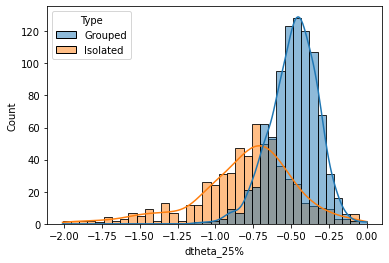

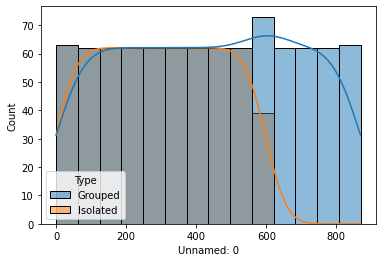

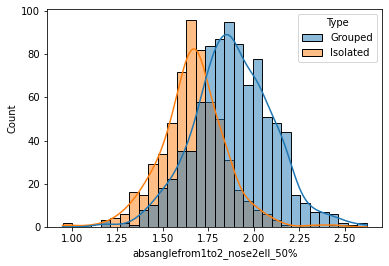

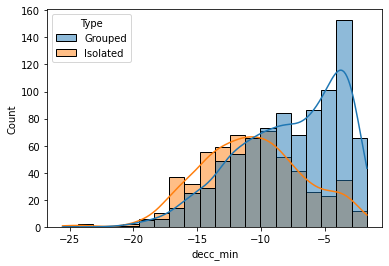

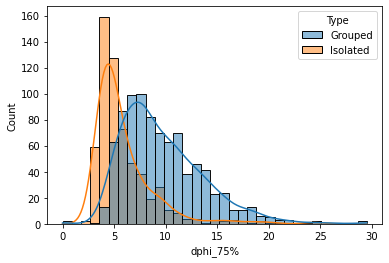

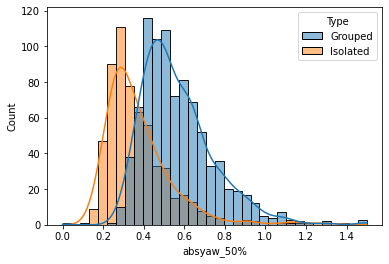

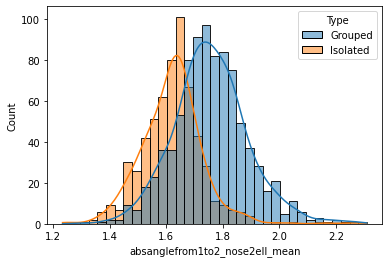

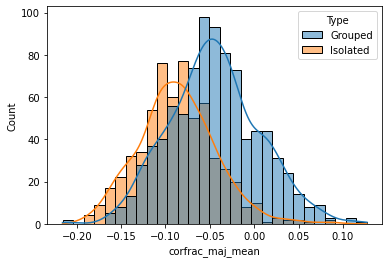

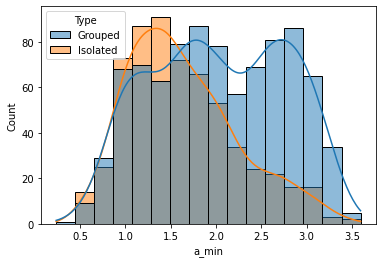

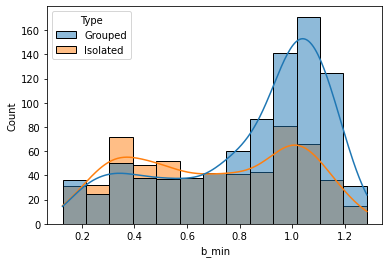

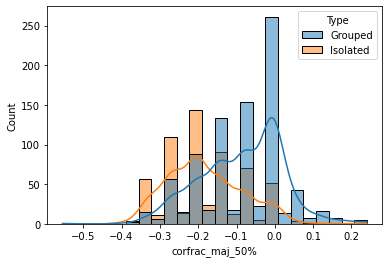

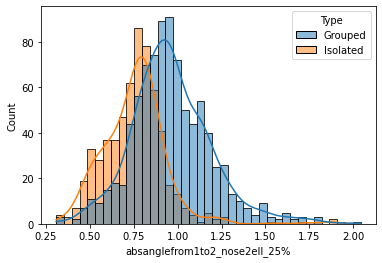

In [64]:
for i in range(selected_features.shape[1]-1):
    ax = sns.histplot(data = analysis_all_data ,x = selected_features.columns[i], hue='Type', kde=True)
    ax.set(xlabel = selected_features.columns[i])
    plt.show()

# Machine Learning Models



Now we are trying to build a model using all these parameters that should be able to detect if a fly is grown in isolation or in a group.


### Functions for generating,training and evaluating models 

In order to check a few models on a few data sets permutation (as we be shown later) we created a few function that train,and evaluate the different models and data set permutations

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [13]:
def generate_accuracy_and_heatmap(model_key,model,x,y,data_set_name,gen_cm=True,gen_hm=False):
    if gen_cm:
        cm = confusion_matrix(y,model.predict(x))
    if gen_hm:
        sns.heatmap(cm,annot=True,fmt="d")
    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x))
    print('Data set name: ', data_set_name)
    print('Model Key: ', model_key)
    print('\n')
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)
    print ("\n")
    print (pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                       pd.Series(np.array(y),name='Actual')))
    if gen_cm:
            print(cm)
            print('\n')
    print("\n")
    return 1

In [14]:
#Set up all the models we would like to run our data on
#We tried basic models in the begining - but in end after adding some new models and changing some parameters
def generate_models():
    models = {}

    # Logistic Regression
    models['Logistic Regression Default'] = LogisticRegression(random_state=0)
    models['Logistic Regression 1'] = LogisticRegression(random_state=0,max_iter=1000,solver='liblinear')
    models['Logistic Regression 2'] = LogisticRegression(random_state=0,max_iter=1000,solver='newton-cg')


    # Decision Trees
    models['Decision Trees Default'] = DecisionTreeClassifier()
    
    #KNNs
    models['KNN N3'] = KNeighborsClassifier(n_neighbors = 3)
    models['KNN N10'] = KNeighborsClassifier(n_neighbors = 10)
    models['KNN N20'] = KNeighborsClassifier(n_neighbors = 20)
    
    return models
        


In [15]:
#Train all models using cross validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

def train_models(models,x_data,y_data):
    trained_models = {}
    model_scores = {}
    for model_key in models.keys():
        model_scores[model_key] = cross_val_score(models[model_key], x_data, y_data, cv=8).mean()
        trained_models[model_key] = models[model_key].fit(x_data,y_data)
        
    return trained_models , model_scores

In [16]:
def predit_and_print_acc(trained_models,x_test,y_test,data_set_name):
    for model_key in trained_models:
        generate_accuracy_and_heatmap(model_key,trained_models[model_key],x_test,y_test,data_set_name)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


#Recevice a dict of trained models and compare there results inside a data frame
def predict_and_compare_models(trained_models,models_cv_scores,x_test,y_test,data_set_name):
    accuracy, precision, recall,predicted,cv_scores = {}, {}, {}, {}, {}
    
    for key in trained_models.keys():
        
        # Prediction 
        predictions = trained_models[key].predict(x_test)
    
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test)
        recall[key] = recall_score(predictions, y_test)
        cv_scores[key] = models_cv_scores[key]
        
    models_comp = pd.DataFrame(index=models.keys(), columns=['Data Set','Accuracy', 'Precision', 'Recall','Cross Val Average Score'])
    models_comp['Accuracy'] = accuracy.values()
    models_comp['Precision'] = precision.values()
    models_comp['Recall'] = recall.values()
    models_comp['Cross Val Average Score'] = cv_scores.values()
    models_comp['Data Set'] = data_set_name

    return models_comp

## Dataset 1- all features

Considering the intersting patterns and distiguisahble features we found in the previous section, we wanted to create and compare several datasets containing different features. First, we created a dataset containing all the possible features. Meaning, the mean, std, min, 1st quart, median, 3st quart and the max.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

param_init_file = "param_init.csv"
param_table = pd.read_csv(param_init_file)  
#result_dir_name = "eda_avi_1/"

param_table_en = param_table[param_table['Enabled'] == 1]
param_list = param_table["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
#param_list = param_list.iloc[0:3]
#choose the param you want

#param_list = ['ddcenter','dcenter']
group_type1='grouped'
group_type2='isolated'
total = []

p = param_list.iloc[0]
param_name=p
#choose group type isolated or grouped
param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

data_grouped = pd.read_csv(param_file_name_1)
data_isolated = pd.read_csv(param_file_name_2)

#Drop un needed columns for the calculation
data_grouped.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
data_isolated.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
total_grouped = data_grouped.transpose().describe()
total_grouped = total_grouped.drop(['count'])
total_isolated = data_isolated.transpose().describe()
total_isolated = total_isolated.drop(['count'])

cols=[]           # This loop dynamically creates of list and appends the column name i.e. the features followed by the timeseries of particular attribute. 
list_cols =['mean','std','min','1st quart','median','3st quart','max']
for param in param_list[0::]:
    for q in range(0,7):
        cols.append(param+'-'+list_cols[q])

    
for p in param_list[1:]:
    param_name=p
    #choose group type isolated or grouped
    param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
    param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

    data_grouped = pd.read_csv(param_file_name_1)
    data_isolated = pd.read_csv(param_file_name_2)

    #Drop un needed columns for the calculation
    data_grouped.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    data_isolated.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    data_grouped_sum = data_grouped.transpose().describe()
    data_grouped_sum = data_grouped_sum.drop(['count'])
    data_isolated_sum = data_isolated.transpose().describe()
    data_isolated_sum = data_isolated_sum.drop(['count'])
    
 
    total_grouped = pd.concat([total_grouped,data_grouped_sum])
    total_isolated = pd.concat([total_isolated,data_isolated_sum])
    
total_grouped = total_grouped.transpose()
total_grouped.columns = cols
total_isolated = total_isolated.transpose()
total_isolated.columns = cols
Y = pd.concat([pd.DataFrame(np.ones([total_grouped.shape[0], 1])),pd.DataFrame(np.zeros([total_isolated.shape[0], 1]))])
X = pd.concat([total_grouped,total_isolated])
tot = pd.concat([X,Y],axis=1)
cols.append('Class')
tot.columns = cols

Save data for further analysis:

In [ ]:
import pickle

with open('my_dataset.pickle', 'wb') as output:
    pickle.dump(tot, output)

Open saved table:

In [18]:
#to run:
import pickle

with open('my_dataset.pickle', 'rb') as data:
    tot = pickle.load(data)

Show table of given features:

In [78]:
tot.head()

a_mm-mean  a_mm-std  a_mm-min  a_mm-1st quart  a_mm-median  a_mm-3st quart  \
0   0.557277  0.026433  0.172454        0.541495     0.561800        0.576585   
1   0.565373  0.029835  0.269141        0.548444     0.566962        0.586235   
2   0.576198  0.029736  0.304787        0.561044     0.580997        0.597037   
3   0.565452  0.024127  0.393875        0.549708     0.566956        0.582670   
4   0.590127  0.029475  0.457889        0.572667     0.595227        0.611577   

   a_mm-max  absanglefrom1to2_nose2ell-mean  absanglefrom1to2_nose2ell-std  \
0  0.689920                        1.771897                       0.867265   
1  0.725690                        1.755278                       0.890155   
2  0.795673                        1.800902                       0.859878   
3  0.742836                        2.041102                       0.837488   
4  0.675685                        1.809553                       0.918757   

   absanglefrom1to2_nose2ell-min  ...  yaw-3st quart   yaw-max  absyaw-mean  \
0                       0.000052  ...       0.528260  3.141496     0.999585   
1                       0.000306  ...       0.558395  3.141274     0.947716   
2                       0.000103  ...       0.688782  3.140617     1.048368   
3                       0.000100  ...       0.699904  3.141167     1.110763   
4                       0.000110  ...       0.496062  3.141372     0.998793   

   absyaw-std  absyaw-min  absyaw-1st quart  absyaw-median  absyaw-3st quart  \
0    1.043828         0.0          0.123187       0.502619          1.868470   
1    0.964205         0.0          0.181027       0.517659          1.580981   
2    0.988859         0.0          0.206779       0.633531          1.856513   
3    1.031309         0.0          0.215667       0.683718          2.036149   
4    1.034852         0.0          0.139036       0.504781          1.847765   

   absyaw-max  Class  
0    3.141496    1.0  
1    3.141274    1.0  
2    3.141179    1.0  
3    3.141405    1.0  
4    3.141372    1.0  

[5 rows x 435 columns]


### Split data
We used 20% of the data for the test and around 10% for validation

In [20]:
indices = np.arange(len(tot))
(X_train,X_test_baseline,Y_train,Y_test_baseline,indices_train,indices_test) = train_test_split(tot.loc[:, tot.columns != 'Class'], tot['Class'], indices, test_size=0.2, random_state=1)
indices_train = np.arange(len(X_train))
X_train_baseline,X_val_baseline,Y_train_baseline,Y_val_baseline,indices_train,indices_val = train_test_split(X_train, Y_train, indices_train, test_size=0.15, random_state=1) # 0.25 x 0.8 = 0.2

In [21]:
models = generate_models()

In [22]:
tr_models_baseline,tr_cv_scores_baseline = train_models(models,X_train_baseline,Y_train_baseline)

In [23]:
predit_and_print_acc(tr_models_baseline,X_val_baseline,Y_val_baseline,'Basic Data Set')

Data set name:  Basic Data Set
Model Key:  Logistic Regression Default


Accuracy is:  0.848314606741573
F1 score is:  0.864321608040201


Actual     0.0  1.0
Predicted          
0.0         65   11
1.0         16   86
[[65 16]
 [11 86]]




Data set name:  Basic Data Set
Model Key:  Logistic Regression 1


Accuracy is:  0.9044943820224719
F1 score is:  0.9137055837563451


Actual     0.0  1.0
Predicted          
0.0         71    7
1.0         10   90
[[71 10]
 [ 7 90]]




Data set name:  Basic Data Set
Model Key:  Logistic Regression 2


Accuracy is:  0.898876404494382
F1 score is:  0.9081632653061225


Actual     0.0  1.0
Predicted          
0.0         71    8
1.0         10   89
[[71 10]
 [ 8 89]]




Data set name:  Basic Data Set
Model Key:  Decision Trees Default


Accuracy is:  0.9044943820224719
F1 score is:  0.9119170984455958


Actual     0.0  1.0
Predicted          
0.0         73    9
1.0          8   88
[[73  8]
 [ 9 88]]




Data set name:  Basic Data Set
Model Key:  K

In [24]:
models_comp_df_baseline = predict_and_compare_models(tr_models_baseline,tr_cv_scores_baseline,X_val_baseline,Y_val_baseline,'Basic Data Set') 
models_comp_df_baseline


Data Set  Accuracy  Precision    Recall  \
Logistic Regression Default  Basic Data Set  0.848315   0.886598  0.843137   
Logistic Regression 1        Basic Data Set  0.904494   0.927835  0.900000   
Logistic Regression 2        Basic Data Set  0.898876   0.917526  0.898990   
Decision Trees Default       Basic Data Set  0.904494   0.907216  0.916667   
KNN N3                       Basic Data Set  0.696629   0.731959  0.717172   
KNN N10                      Basic Data Set  0.685393   0.701031  0.715789   
KNN N20                      Basic Data Set  0.685393   0.762887  0.691589   

                             Cross Val Average Score  
Logistic Regression Default                 0.868635  
Logistic Regression 1                       0.913405  
Logistic Regression 2                       0.914405  
Decision Trees Default                      0.850730  
KNN N3                                      0.636794  
KNN N10                                     0.649738  
KNN N20                                     0.652659

In [25]:
best_baseline = models_comp_df_baseline.nlargest(1,'Accuracy')
best_baseline

Data Set  Accuracy  Precision  Recall  \
Logistic Regression 1  Basic Data Set  0.904494   0.927835     0.9   

                       Cross Val Average Score  
Logistic Regression 1                 0.913405

## Dataset 2- moving average

Next, we create a model based on the smoothed data of each fly, as described above.
We create a data set using the describe function as before, this time on the smoothed data:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
%matplotlib inline

param_init_file = "param_init.csv"
param_table = pd.read_csv(param_init_file)  
#result_dir_name = "eda_avi_1/"
#Moving average window
window=5000

param_table_en = param_table[param_table['Enabled'] == 1]
param_list = param_table["Param"].map(lambda x: x.lstrip("'").rstrip("''"))
#param_list = param_list.iloc[0:3]
#choose the param you want

#param_list = ['ddcenter','dcenter']
group_type1='grouped'
group_type2='isolated'
total = []

p = param_list.iloc[0]
param_name=p
#choose group type isolated or grouped
param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

data_grouped = pd.read_csv(param_file_name_1)
data_isolated = pd.read_csv(param_file_name_2)

#Drop un needed columns for the calculation
data_grouped.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
data_isolated.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
for i in (range(len(data_grouped))):
        data_grouped.iloc[i] = data_grouped.iloc[i].rolling(window=window).mean()
for i in (range(len(data_isolated))):
        data_isolated.iloc[i] = data_isolated.iloc[i].rolling(window=window).mean()
        
total_grouped = data_grouped.transpose().describe()
total_grouped = total_grouped.drop(['count'])
total_isolated = data_isolated.transpose().describe()
total_isolated = total_isolated.drop(['count'])

cols=[]           # This loop dynamically creates of list and appends the column name i.e. the features followed by the timeseries of particular attribute. 
list_cols =['mean','std','min','1st quart','median','3st quart','max']
for param in param_list[0::]:
    for q in range(0,7):
        cols.append(param+'-'+list_cols[q])

    
for p in tqdm(param_list[1::]):
    param_name=p
    #choose group type isolated or grouped
    param_file_name_1="{grp_dir}/{par_name}.csv".format(grp_dir=group_type1,par_name = param_name)
    param_file_name_2="{grp_dir}/{par_name}.csv".format(grp_dir=group_type2,par_name = param_name)

    data_grouped = pd.read_csv(param_file_name_1)
    data_isolated = pd.read_csv(param_file_name_2)

    #Drop un needed columns for the calculation
    data_grouped.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    data_isolated.drop(['Unnamed: 0', 'param', 'fly','dir'],axis=1,inplace=True)
    #data_grouped.apply(pd.DataFrame.rolling(window=5000).mean(),axis=1,inplace=True)
    for i in (range(len(data_grouped))):
            data_grouped.iloc[i] = data_grouped.iloc[i].rolling(window=window).mean()
    for i in (range(len(data_isolated))):
            data_isolated.iloc[i] = data_isolated.iloc[i].rolling(window=window).mean()

    data_grouped_sum = data_grouped.transpose().describe()
    data_grouped_sum = data_grouped_sum.drop(['count'])
    data_isolated_sum = data_isolated.transpose().describe()
    data_isolated_sum = data_isolated_sum.drop(['count'])
    
 
    total_grouped = pd.concat([total_grouped,data_grouped_sum])
    total_isolated = pd.concat([total_isolated,data_isolated_sum])
    
total_grouped = total_grouped.transpose()
total_grouped.columns = cols
total_isolated = total_isolated.transpose()
total_isolated.columns = cols
Y = pd.concat([pd.DataFrame(np.ones([total_grouped.shape[0], 1])),pd.DataFrame(np.zeros([total_isolated.shape[0], 1]))])
X = pd.concat([total_grouped,total_isolated])
tot_smooth = pd.concat([X,Y],axis=1)
cols.append('Class')
tot_smooth.columns = cols

Save data for further analysis

In [ ]:
import pickle

with open('my_dataset_smooth.pickle', 'wb') as output:
    pickle.dump(tot_smooth, output)

Open saved dataset

In [26]:
import pickle

with open('my_dataset_smooth.pickle', 'rb') as data:
    tot_smooth = pickle.load(data)

In [90]:
tot_smooth.head()

a_mm-mean  a_mm-std  a_mm-min  a_mm-1st quart  a_mm-median  a_mm-3st quart  \
0   0.557176  0.006130  0.543913        0.553109     0.559298        0.562399   
1   0.562684  0.017259  0.542274        0.550463     0.555383        0.581421   
2   0.576578  0.019412  0.538937        0.556799     0.586248        0.591387   
3   0.565297  0.005374  0.554887        0.562476     0.565465        0.569247   
4   0.588460  0.005631  0.571475        0.585201     0.587900        0.592450   

   a_mm-max  absanglefrom1to2_nose2ell-mean  absanglefrom1to2_nose2ell-std  \
0  0.565512                        1.758524                       0.182021   
1  0.595357                        1.747262                       0.105284   
2  0.596534                        1.787130                       0.083027   
3  0.576916                        2.029999                       0.199232   
4  0.601900                        1.824621                       0.226555   

   absanglefrom1to2_nose2ell-min  ...  yaw-3st quart   yaw-max  absyaw-mean  \
0                       1.451935  ...       0.030473  0.064823     0.985300   
1                       1.551004  ...       0.088740  0.158098     0.976956   
2                       1.595130  ...       0.104720  0.135132     1.107391   
3                       1.737112  ...       0.021539  0.070710     1.130125   
4                       1.439562  ...       0.001504  0.056366     0.979929   

   absyaw-std  absyaw-min  absyaw-1st quart  absyaw-median  absyaw-3st quart  \
0    0.278899    0.604285          0.770444       0.891088          1.240732   
1    0.216544    0.634228          0.822282       0.948694          1.121996   
2    0.213845    0.449823          1.041922       1.169326          1.224832   
3    0.208400    0.663515          1.047904       1.118218          1.245145   
4    0.252876    0.665649          0.813635       0.892373          1.013823   

   absyaw-max  Class  
0    1.473386    1.0  
1    1.417773    1.0  
2    1.404599    1.0  
3    1.482452    1.0  
4    1.510754    1.0  

[5 rows x 435 columns]

Use prevoiusly detemined splitting (the indices we generated in the original split). We want the models/data sets to all train on the same flies

In [27]:

train_sm = tot_smooth.iloc[indices_train]
val_sm = tot_smooth.iloc[indices_val]
test_sm = tot_smooth.iloc[indices_test]

Y_train_sm = train_sm['Class']
X_train_sm = train_sm.drop(['Class'],axis=1)
Y_val_sm = val_sm['Class']
X_val_sm = val_sm.drop(['Class'],axis=1)
Y_test_sm = test_sm['Class']
X_test_sm = test_sm.drop(['Class'],axis=1)


In [28]:
tr_models_sm,tr_cv_scores_sm = train_models(models,X_train_sm,Y_train_sm)

The moving average data set trained a lot faster than the regular data set - could that be beccause the data is less noisy?

In [29]:
predit_and_print_acc(tr_models_sm,X_val_sm,Y_val_sm,'Smoothed Data Set')

Data set name:  Smoothed Data Set
Model Key:  Logistic Regression Default


Accuracy is:  0.9438202247191011
F1 score is:  0.9606299212598425


Actual     0.0  1.0
Predicted          
0.0         46    4
1.0          6  122
[[ 46   6]
 [  4 122]]




Data set name:  Smoothed Data Set
Model Key:  Logistic Regression 1


Accuracy is:  0.9662921348314607
F1 score is:  0.9763779527559054


Actual     0.0  1.0
Predicted          
0.0         48    2
1.0          4  124
[[ 48   4]
 [  2 124]]




Data set name:  Smoothed Data Set
Model Key:  Logistic Regression 2


Accuracy is:  0.9606741573033708
F1 score is:  0.9725490196078431


Actual     0.0  1.0
Predicted          
0.0         47    2
1.0          5  124
[[ 47   5]
 [  2 124]]




Data set name:  Smoothed Data Set
Model Key:  Decision Trees Default


Accuracy is:  0.898876404494382
F1 score is:  0.9285714285714286


Actual     0.0  1.0
Predicted          
0.0         43    9
1.0          9  117
[[ 43   9]
 [  9 117]]




Data set name:

In [30]:
models_comp_df_sm = predict_and_compare_models(tr_models_sm,tr_cv_scores_sm,X_val_sm,Y_val_sm,'Smoothed Data Set') 
models_comp_df_sm

Data Set  Accuracy  Precision    Recall  \
Logistic Regression Default  Smoothed Data Set  0.943820   0.968254  0.953125   
Logistic Regression 1        Smoothed Data Set  0.966292   0.984127  0.968750   
Logistic Regression 2        Smoothed Data Set  0.960674   0.984127  0.961240   
Decision Trees Default       Smoothed Data Set  0.898876   0.928571  0.928571   
KNN N3                       Smoothed Data Set  0.859551   0.920635  0.885496   
KNN N10                      Smoothed Data Set  0.893258   0.960317  0.896296   
KNN N20                      Smoothed Data Set  0.898876   0.984127  0.885714   

                             Cross Val Average Score  
Logistic Regression Default                 0.923389  
Logistic Regression 1                       0.951286  
Logistic Regression 2                       0.947310  
Decision Trees Default                      0.890556  
KNN N3                                      0.887540  
KNN N10                                     0.890524  
KNN N20                                     0.880595

In [31]:
best_sm = models_comp_df_sm.nlargest(1,'Accuracy')
best_sm

Data Set  Accuracy  Precision   Recall  \
Logistic Regression 1  Smoothed Data Set  0.966292   0.984127  0.96875   

                       Cross Val Average Score  
Logistic Regression 1                 0.951286

In [32]:
all_models_1 = pd.concat([best_baseline, best_sm])
all_models_1

Data Set  Accuracy  Precision   Recall  \
Logistic Regression 1     Basic Data Set  0.904494   0.927835  0.90000   
Logistic Regression 1  Smoothed Data Set  0.966292   0.984127  0.96875   

                       Cross Val Average Score  
Logistic Regression 1                 0.913405  
Logistic Regression 1                 0.951286

We see that dataset# gave overall better results, therfore will will contunie to improving the model based on this dataset.

# Features elimination

## Dataset 3- 30 features

When the number of features increases beyond the number of samples, it gets difficult to estimate the prediction. So, we go for feature elimination.
First we created a dataset based on 30 selected features from EDA Analysis based on maximum mean distance between both classes

In [98]:
selected_features.head()

ddcenter_25%  absyaw_75%  danglesub_min  dv_cor_25%  dv_ctr_25%  dphi_std  \
0      0.904080    0.631863       0.073860    0.970199    0.923623  0.617783   
1      0.833765    0.516278       0.562266    0.832460    0.725504  0.544567   
2      0.859483    0.627056       0.179129    0.923631    0.814654  0.639988   
3      0.948664    0.699279       0.626477    0.974786    0.921629  0.657053   
4      0.867106    0.623539       0.564916    0.960589    0.904113  0.573720   

   ddist2wall_25%  dangle2wall_25%  area_min  dcenter_min  ...  decc_min  \
0        0.952077         0.792723  0.068326     0.010810  ...  0.648257   
1        0.879309         0.610580  0.445472     0.716184  ...  0.793937   
2        0.898340         0.669723  0.732382     0.010810  ...  0.753819   
3        0.954681         0.823229  0.548979     0.699121  ...  0.864074   
4        0.926025         0.720439  0.829421     0.726790  ...  0.924326   

   dphi_75%  absyaw_50%  absanglefrom1to2_nose2ell_mean  corfrac_maj_mean  \
0  0.317879    0.334950                        0.500681          0.482733   
1  0.281883    0.344973                        0.485240          0.623017   
2  0.396645    0.422191                        0.527630          0.734099   
3  0.421130    0.455637                        0.750807          0.511499   
4  0.281032    0.336391                        0.535669          0.483933   

      a_min     b_min  corfrac_maj_50%  absanglefrom1to2_nose2ell_25%    Class  
0  0.000000  0.184980         0.597702                       0.398907  Grouped  
1  0.474498  0.837400         0.677515                       0.392689  Grouped  
2  0.546601  0.822623         0.792404                       0.471195  Grouped  
3  0.726803  0.784840         0.597702                       0.726858  Grouped  
4  0.856287  0.939063         0.519147                       0.378471  Grouped  

[5 rows x 31 columns]

In [33]:
selected_features['Class']= 1
selected_features[870:]['Class']= 0

group = selected_features[selected_features['Class']==1]
group.shape

(870, 31)

In [34]:
selected_features['Class']= 1
selected_features[870:]['Class']= 0

train_sel_fea = selected_features.iloc[indices_train]
val_sel_fea = selected_features.iloc[indices_val]
test_sel_fea = selected_features.iloc[indices_test]

Y_train_sel_fea = train_sel_fea['Class']
X_train_sel_fea = train_sel_fea.drop(['Class'],axis=1)
Y_val_sel_fea = val_sel_fea['Class']
X_val_sel_fea = val_sel_fea.drop(['Class'],axis=1)
Y_test_sel_fea = test_sel_fea['Class']
X_test_sel_fea = test_sel_fea.drop(['Class'],axis=1)

In [35]:
tr_models_sel_fea,tr_cv_scores_sel_fea = train_models(models,X_train_sel_fea,Y_train_sel_fea)

Here, we noticed that training was extremely fast - probably because there is much less features

In [36]:
predit_and_print_acc(tr_models_sel_fea,X_val_sel_fea,Y_val_sel_fea,'Selected_features')

Data set name:  Selected_features
Model Key:  Logistic Regression Default


Accuracy is:  0.9325842696629213
F1 score is:  0.953125


Actual      0    1
Predicted         
0          44    4
1           8  122
[[ 44   8]
 [  4 122]]




Data set name:  Selected_features
Model Key:  Logistic Regression 1


Accuracy is:  0.9269662921348315
F1 score is:  0.9498069498069498


Actual      0    1
Predicted         
0          42    3
1          10  123
[[ 42  10]
 [  3 123]]




Data set name:  Selected_features
Model Key:  Logistic Regression 2


Accuracy is:  0.9325842696629213
F1 score is:  0.953125


Actual      0    1
Predicted         
0          44    4
1           8  122
[[ 44   8]
 [  4 122]]




Data set name:  Selected_features
Model Key:  Decision Trees Default


Accuracy is:  0.9382022471910112
F1 score is:  0.9551020408163267


Actual      0    1
Predicted         
0          50    9
1           2  117
[[ 50   2]
 [  9 117]]




Data set name:  Selected_features
Model Key:  KNN

In [37]:
models_comp_df_sel_fea = predict_and_compare_models(tr_models_sel_fea,tr_cv_scores_sel_fea,X_val_sel_fea,Y_val_sel_fea,'Selected_features') 
models_comp_df_sel_fea

Data Set  Accuracy  Precision    Recall  \
Logistic Regression Default  Selected_features  0.932584   0.968254  0.938462   
Logistic Regression 1        Selected_features  0.926966   0.976190  0.924812   
Logistic Regression 2        Selected_features  0.932584   0.968254  0.938462   
Decision Trees Default       Selected_features  0.938202   0.928571  0.983193   
KNN N3                       Selected_features  0.921348   0.952381  0.937500   
KNN N10                      Selected_features  0.921348   0.936508  0.951613   
KNN N20                      Selected_features  0.926966   0.960317  0.937984   

                             Cross Val Average Score  
Logistic Regression Default                 0.925413  
Logistic Regression 1                       0.928389  
Logistic Regression 2                       0.925413  
Decision Trees Default                      0.934325  
KNN N3                                      0.917484  
KNN N10                                     0.915460  
KNN N20                                     0.916413

In [38]:
best_sel_fea = models_comp_df_sel_fea.nlargest(1,'Accuracy')
best_sel_fea

Data Set  Accuracy  Precision    Recall  \
Decision Trees Default  Selected_features  0.938202   0.928571  0.983193   

                        Cross Val Average Score  
Decision Trees Default                 0.934325

In [39]:
all_models_2 = pd.concat([all_models_1, best_sel_fea])
all_models_2

Data Set  Accuracy  Precision    Recall  \
Logistic Regression 1      Basic Data Set  0.904494   0.927835  0.900000   
Logistic Regression 1   Smoothed Data Set  0.966292   0.984127  0.968750   
Decision Trees Default  Selected_features  0.938202   0.928571  0.983193   

                        Cross Val Average Score  
Logistic Regression 1                  0.913405  
Logistic Regression 1                  0.951286  
Decision Trees Default                 0.934325

## Dataset 4- advanced feature selection

Next, we used a more advanced method for feature selection, called Reduced Feature Eimination with Cross Validation. The model uses the estiamator as Logistic Regression and validates on 5 folds. The RFECV model extracts essential features from the set of features and cross validates on the validation set bringing a good train accuracy.

In [40]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train_sm, Y_train_sm)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train_sm.columns[rfecv.support_])

Optimal number of features : 90
Best features : Index(['absanglefrom1to2_nose2ell-mean', 'absanglefrom1to2_nose2ell-1st quart',
       'absanglefrom1to2_nose2ell-median',
       'absanglefrom1to2_nose2ell-3st quart', 'absanglefrom1to2_nose2ell-max',
       'absdv_cor-std', 'absdv_cor-median', 'absdv_cor-3st quart',
       'absdv_cor-max', 'absphidiff_anglesub-max', 'absphidiff_nose2ell-mean',
       'absphidiff_nose2ell-1st quart', 'absphidiff_nose2ell-median',
       'absphidiff_nose2ell-3st quart', 'absphidiff_nose2ell-max',
       'absthetadiff_anglesub-std', 'absthetadiff_anglesub-min',
       'absthetadiff_nose2ell-std', 'absthetadiff_nose2ell-min',
       'absthetadiff_nose2ell-3st quart', 'absthetadiff_nose2ell-max',
       'angle2wall-std', 'angle2wall-min', 'angle2wall-3st quart',
       'angle2wall-max', 'anglefrom1to2_anglesub-max',
       'anglefrom1to2_nose2ell-std', 'anglefrom1to2_nose2ell-min',
       'anglefrom1to2_nose2ell-median', 'anglefrom1to2_nose2ell-3st quart',
 

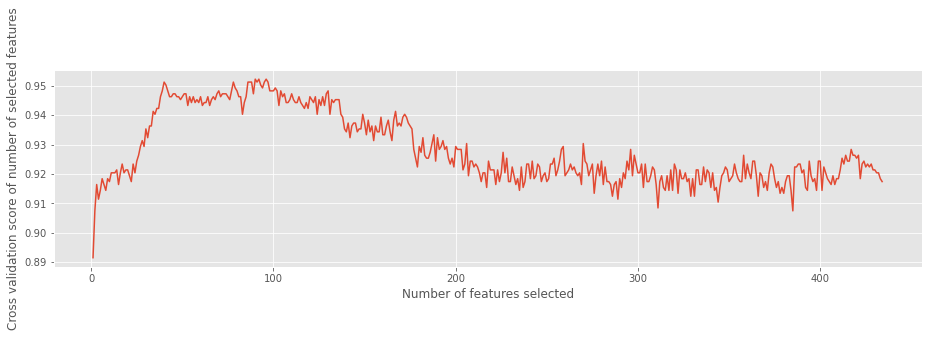

In [41]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [42]:
X_train_rfecv = X_train_sm[X_train_sm.columns[rfecv.support_]]
X_val_rfecv = X_val_sm[X_val_sm.columns[rfecv.support_]]
X_test_rfecv = X_test_sm[X_test_sm.columns[rfecv.support_]]

Model on selected features:

In [43]:
tr_models_rfecv,tr_cv_scores_rfecv = train_models(models,X_train_rfecv,Y_train_sm)

In [44]:
predit_and_print_acc(tr_models_rfecv,X_val_rfecv,Y_val_sm,'RFECV Data Set')

Data set name:  RFECV Data Set
Model Key:  Logistic Regression Default


Accuracy is:  0.9606741573033708
F1 score is:  0.9727626459143969


Actual     0.0  1.0
Predicted          
0.0         46    1
1.0          6  125
[[ 46   6]
 [  1 125]]




Data set name:  RFECV Data Set
Model Key:  Logistic Regression 1


Accuracy is:  0.9606741573033708
F1 score is:  0.9727626459143969


Actual     0.0  1.0
Predicted          
0.0         46    1
1.0          6  125
[[ 46   6]
 [  1 125]]




Data set name:  RFECV Data Set
Model Key:  Logistic Regression 2


Accuracy is:  0.9606741573033708
F1 score is:  0.9727626459143969


Actual     0.0  1.0
Predicted          
0.0         46    1
1.0          6  125
[[ 46   6]
 [  1 125]]




Data set name:  RFECV Data Set
Model Key:  Decision Trees Default


Accuracy is:  0.9325842696629213
F1 score is:  0.9527559055118109


Actual     0.0  1.0
Predicted          
0.0         45    5
1.0          7  121
[[ 45   7]
 [  5 121]]




Data set name:  RFECV Dat

In [45]:
models_comp_df_rfecv = predict_and_compare_models(tr_models_rfecv,tr_cv_scores_rfecv,X_val_rfecv,Y_val_sm,'RFECV Data Set') 
models_comp_df_rfecv

Data Set  Accuracy  Precision    Recall  \
Logistic Regression Default  RFECV Data Set  0.960674   0.992063  0.954198   
Logistic Regression 1        RFECV Data Set  0.960674   0.992063  0.954198   
Logistic Regression 2        RFECV Data Set  0.960674   0.992063  0.954198   
Decision Trees Default       RFECV Data Set  0.932584   0.960317  0.945312   
KNN N3                       RFECV Data Set  0.904494   0.944444  0.922481   
KNN N10                      RFECV Data Set  0.882022   0.944444  0.894737   
KNN N20                      RFECV Data Set  0.876404   0.952381  0.882353   

                             Cross Val Average Score  
Logistic Regression Default                 0.951230  
Logistic Regression 1                       0.950246  
Logistic Regression 2                       0.953230  
Decision Trees Default                      0.881643  
KNN N3                                      0.898532  
KNN N10                                     0.910460  
KNN N20                                     0.909476

In [46]:
best_rfecv = models_comp_df_rfecv.nlargest(1,'Accuracy')
best_rfecv

Data Set  Accuracy  Precision    Recall  \
Logistic Regression Default  RFECV Data Set  0.960674   0.992063  0.954198   

                             Cross Val Average Score  
Logistic Regression Default                  0.95123

In [47]:
all_models_3 = pd.concat([all_models_2,best_rfecv])
all_models_3

Data Set  Accuracy  Precision    Recall  \
Logistic Regression 1           Basic Data Set  0.904494   0.927835  0.900000   
Logistic Regression 1        Smoothed Data Set  0.966292   0.984127  0.968750   
Decision Trees Default       Selected_features  0.938202   0.928571  0.983193   
Logistic Regression Default     RFECV Data Set  0.960674   0.992063  0.954198   

                             Cross Val Average Score  
Logistic Regression 1                       0.913405  
Logistic Regression 1                       0.951286  
Decision Trees Default                      0.934325  
Logistic Regression Default                 0.951230

# Balance Data

The number of isolated and grouped flies is not equal, therefore balancing the data can result in a more aqurate accuracy. The number of samples from each group is presented below:

In [48]:
all_train_rfecv = pd.concat([X_train_rfecv,Y_train_sm],axis=1)

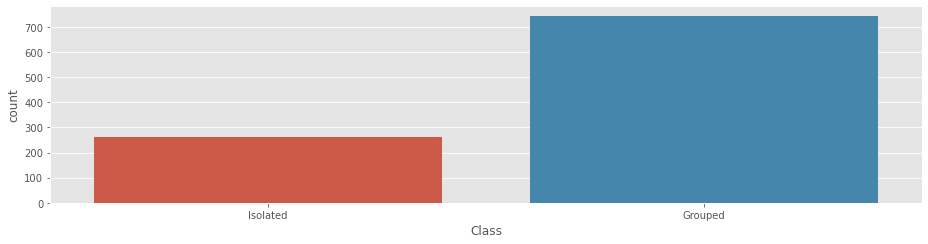

1.0    744
0.0    261
Name: Class, dtype: int64

In [49]:
g = sns.countplot(all_train_rfecv['Class'])
g.set_xticklabels(['Isolated','Grouped'])
plt.show()
all_train_rfecv['Class'].value_counts()

We will start by separating the class that will be 0 and class 1.

In [50]:
# class count
class_count_1, class_count_0 = all_train_rfecv['Class'].value_counts()

# Separate class
class_1 = all_train_rfecv[all_train_rfecv['Class'] == 1]
class_0 = all_train_rfecv[all_train_rfecv['Class'] == 0]# print the shape of the class
#print('class 0:', class_count_0)
#print('class 1:', class_count_1)

Due to the low number of smaples, we choose to try oversampling methods. Oversampling can be defined as adding more copies to the minority class, which is suitable to cases of small data.

## Method 1- Random Oversampling

Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.
Random oversampling duplicates examples from the minority class in the training dataset.

advantage: based on only real data.

disadvatage: can result in overfitting.

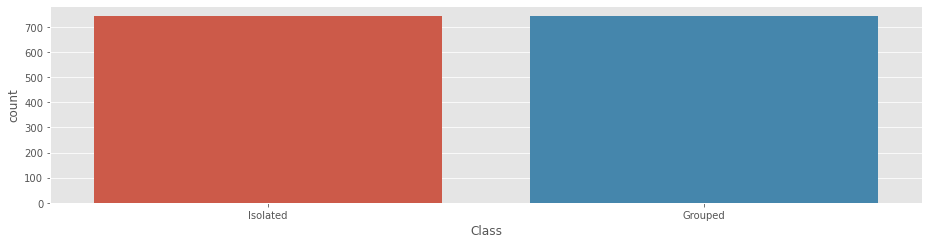

1.0    744
0.0    744
Name: Class, dtype: int64

In [51]:
class_0_over = class_0.sample(class_count_1, replace=True)
train_over = pd.concat([class_0_over, class_1], axis=0)

#print("total class of 1 and 0:",test_under['Class'].value_counts())# plot the count after under-sampeling
#train_over['Class'].value_counts().plot(kind='bar', title='count (target)')
g = sns.countplot(train_over['Class'])
g.set_xticklabels(['Isolated','Grouped'])
plt.show()
train_over['Class'].value_counts()

Present new dataframe:

In [52]:
train_over = train_over.sample(frac=1)
train_over.head()

absanglefrom1to2_nose2ell-mean  absanglefrom1to2_nose2ell-1st quart  \
475                        1.680814                             1.568415   
459                        1.803142                             1.757637   
222                        1.663768                             1.522852   
239                        1.519785                             1.461125   
211                        1.718523                             1.571977   

     absanglefrom1to2_nose2ell-median  absanglefrom1to2_nose2ell-3st quart  \
475                          1.692327                             1.771571   
459                          1.791706                             1.830129   
222                          1.628382                             1.826030   
239                          1.509309                             1.588363   
211                          1.754302                             1.828820   

     absanglefrom1to2_nose2ell-max  absdv_cor-std  absdv_cor-median  \
475                       2.063473       0.533444          1.426221   
459                       1.964377       0.409574          1.618030   
222                       2.046394       0.403475          1.005371   
239                       1.662956       0.484951          2.713928   
211                       1.977528       0.491738          2.191612   

     absdv_cor-3st quart  absdv_cor-max  absphidiff_anglesub-max  ...  \
475             1.972616       2.562092                 1.635649  ...   
459             1.809447       2.087406                 1.627095  ...   
222             1.229424       1.844457                 1.642714  ...   
239             3.130978       3.756184                 1.597001  ...   
211             2.609017       3.103989                 1.609547  ...   

     velmag_ctr-std  velmag_nose-mean  velmag_nose-std  velmag_nose-min  \
475        3.044928          9.349072         3.278560         2.361781   
459        2.330930          8.358872         2.375220         4.675629   
222        1.744154          4.793673         1.889783         0.925831   
239        2.280183         14.592077         2.389842        10.615009   
211        2.628587         12.514170         2.750189         5.677428   

     velmag_nose-1st quart  velmag_nose-median  velmag_nose-3st quart  \
475               7.375793            9.289148              12.063128   
459               5.877705            9.038875              10.450014   
222               3.735041            5.201050               6.136954   
239              11.851536           15.586527              16.593242   
211              11.032103           12.820768              14.804189   

     velmag_nose-max  velmag_tail-std  Class  
475        16.434899         3.097000    1.0  
459        12.561424         2.307436    1.0  
222         8.977401         1.752937    1.0  
239        18.195091         2.328124    0.0  
211        16.933058         2.657906    0.0  

[5 rows x 91 columns]

In [53]:
Y_train_rand = train_over['Class']
X_train_rand = train_over.loc[:, train_over.columns != 'Class']

In [54]:
tr_models_rand,tr_cv_scores_rand = train_models(models,X_train_rand,Y_train_rand)

In [55]:
predit_and_print_acc(tr_models_rand,X_val_rfecv,Y_val_sm,'RFECV Data Set')

Data set name:  RFECV Data Set
Model Key:  Logistic Regression Default


Accuracy is:  0.9550561797752809
F1 score is:  0.9680000000000001


Actual     0.0  1.0
Predicted          
0.0         49    5
1.0          3  121
[[ 49   3]
 [  5 121]]




Data set name:  RFECV Data Set
Model Key:  Logistic Regression 1


Accuracy is:  0.9438202247191011
F1 score is:  0.9596774193548386


Actual     0.0  1.0
Predicted          
0.0         49    7
1.0          3  119
[[ 49   3]
 [  7 119]]




Data set name:  RFECV Data Set
Model Key:  Logistic Regression 2


Accuracy is:  0.9438202247191011
F1 score is:  0.9596774193548386


Actual     0.0  1.0
Predicted          
0.0         49    7
1.0          3  119
[[ 49   3]
 [  7 119]]




Data set name:  RFECV Data Set
Model Key:  Decision Trees Default


Accuracy is:  0.9044943820224719
F1 score is:  0.933852140077821


Actual     0.0  1.0
Predicted          
0.0         41    6
1.0         11  120
[[ 41  11]
 [  6 120]]




Data set name:  RFECV Data

In [69]:
models_comp_df_rand = predict_and_compare_models(tr_models_rand,tr_cv_scores_rand,X_val_rfecv,Y_val_sm,'Random Balance Data Set') 
models_comp_df_rand

Data Set  Accuracy  Precision  \
Logistic Regression Default  Random Balance Data Set  0.955056   0.960317   
Logistic Regression 1        Random Balance Data Set  0.943820   0.944444   
Logistic Regression 2        Random Balance Data Set  0.943820   0.944444   
Decision Trees Default       Random Balance Data Set  0.904494   0.952381   
KNN N3                       Random Balance Data Set  0.887640   0.896825   
KNN N10                      Random Balance Data Set  0.814607   0.801587   
KNN N20                      Random Balance Data Set  0.865169   0.865079   

                               Recall  Cross Val Average Score  
Logistic Regression Default  0.975806                 0.942876  
Logistic Regression 1        0.975410                 0.949597  
Logistic Regression 2        0.975410                 0.953629  
Decision Trees Default       0.916031                 0.951613  
KNN N3                       0.941667                 0.908602  
KNN N10                      0.926606                 0.882392  
KNN N20                      0.939655                 0.875672

In [70]:
best_rand = models_comp_df_rand.nlargest(1,'Accuracy')
best_rand

Data Set  Accuracy  Precision  \
Logistic Regression Default  Random Balance Data Set  0.955056   0.960317   

                               Recall  Cross Val Average Score  
Logistic Regression Default  0.975806                 0.942876

In [71]:
all_models_4 = pd.concat([all_models_3,best_rand])
all_models_4

Data Set  Accuracy  Precision  \
Logistic Regression 1                 Basic Data Set  0.904494   0.927835   
Logistic Regression 1              Smoothed Data Set  0.966292   0.984127   
Decision Trees Default             Selected_features  0.938202   0.928571   
Logistic Regression Default           RFECV Data Set  0.960674   0.992063   
Logistic Regression Default  Random Balance Data Set  0.955056   0.960317   

                               Recall  Cross Val Average Score  
Logistic Regression 1        0.900000                 0.913405  
Logistic Regression 1        0.968750                 0.951286  
Decision Trees Default       0.983193                 0.934325  
Logistic Regression Default  0.954198                 0.951230  
Logistic Regression Default  0.975806                 0.942876

Accuracy is lowered after random sampling. This makes sense because maybe the model is more accuracte now because it reflects a more balanced data set

To try and improve accuracy and rebalance the data we used the SMOTE method

## SMOTE sampling method:

Onother technique is based on learning the data and synthsizing new data. Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.
The approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class.

Note - we ran smote in a different environment but in the final notebook we didn't have imblearn installed and we couldn't do the entire learning and modeling again :(

In [59]:
import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rfecv, Y_train_sm.ravel())
g = sns.countplot(y_train_res)
g.set_xticklabels(['Isolated','Grouped'])
plt.show()
#y_train_res.value_counts()

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


ModuleNotFoundError: No module named 'imblearn'

In [186]:
tr_models_smote,tr_cv_scores_smote = train_models(models,X_train_smote, y_train_smote)

C:\Users\User\anaconda3\anacona\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\anacona\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [187]:
predit_and_print_acc(tr_models_smote,X_test_rfecv,Y_test_sm,'Smote Balance Data Set')

Data set name:  Smote Balance Data Set
Model Key:  Logistic Regression Default


Accuracy is:  0.8986486486486487
F1 score is:  0.912280701754386


Actual     0.0  1.0
Predicted          
0.0        110   18
1.0         12  156
[[110  12]
 [ 18 156]]




Data set name:  Smote Balance Data Set
Model Key:  Logistic Regression 1


Accuracy is:  0.8986486486486487
F1 score is:  0.912280701754386


Actual     0.0  1.0
Predicted          
0.0        110   18
1.0         12  156
[[110  12]
 [ 18 156]]




Data set name:  Smote Balance Data Set
Model Key:  Logistic Regression 2


Accuracy is:  0.8986486486486487
F1 score is:  0.912280701754386


Actual     0.0  1.0
Predicted          
0.0        110   18
1.0         12  156
[[110  12]
 [ 18 156]]




Data set name:  Smote Balance Data Set
Model Key:  Decision Trees Default


Accuracy is:  0.8682432432432432
F1 score is:  0.8869565217391304


Actual     0.0  1.0
Predicted          
0.0        104   21
1.0         18  153
[[104  18]
 [ 21 153]]


In [190]:
models_comp_df_smote = predict_and_compare_models(tr_models_smote,tr_cv_scores_smote,X_test_rfecv,Y_test_sm,'Smote Balance Data Set') 
models_comp_df_smote

Data Set  Accuracy  Precision  \
Logistic Regression Default  Smote Balance Data Set  0.898649   0.896552   
Logistic Regression 1        Smote Balance Data Set  0.898649   0.896552   
Logistic Regression 2        Smote Balance Data Set  0.898649   0.896552   
Decision Trees Default       Smote Balance Data Set  0.868243   0.879310   
KNN N3                       Smote Balance Data Set  0.871622   0.856322   
KNN N10                      Smote Balance Data Set  0.868243   0.821839   
KNN N20                      Smote Balance Data Set  0.868243   0.839080   

                               Recall  Cross Val Average Score  
Logistic Regression Default  0.928571                 0.911638  
Logistic Regression 1        0.928571                 0.911638  
Logistic Regression 2        0.928571                 0.910920  
Decision Trees Default       0.894737                 0.857040  
KNN N3                       0.919753                 0.872126  
KNN N10                      0.947020                 0.853448  
KNN N20                      0.929936                 0.858477

In [191]:
best_smote = models_comp_df_smote.nlargest(2,'Accuracy')
best_smote

Data Set  Accuracy  Precision  \
Logistic Regression Default  Smote Balance Data Set  0.898649   0.896552   
Logistic Regression 1        Smote Balance Data Set  0.898649   0.896552   

                               Recall  Cross Val Average Score  
Logistic Regression Default  0.928571                 0.911638  
Logistic Regression 1        0.928571                 0.911638

# Final Analysis

The preferable model/s:

In [60]:
best = all_models_4
best

Data Set  Accuracy  Precision  \
Logistic Regression 1                 Basic Data Set  0.904494   0.927835   
Logistic Regression 1              Smoothed Data Set  0.966292   0.984127   
Decision Trees Default             Selected_features  0.938202   0.928571   
Logistic Regression Default           RFECV Data Set  0.960674   0.992063   
Decision Trees Default       Random Balance Data Set  0.915541   0.988764   

                               Recall  Cross Val Average Score  
Logistic Regression 1        0.900000                 0.913405  
Logistic Regression 1        0.968750                 0.951286  
Decision Trees Default       0.983193                 0.934325  
Logistic Regression Default  0.954198                 0.951230  
Decision Trees Default       0.884422                 0.951613

In [130]:
# Calculate Accuracy, Precision and Recall Metrics
generate_accuracy_and_heatmap('Logistic Regression Default',tr_models_rfecv['Logistic Regression Default'],X_test_rfecv,Y_test_sm,'RFECV Data Set')
        

Data set name:  RFECV Data Set
Model Key:  Logistic Regression Default


Accuracy is:  0.8648648648648649
F1 score is:  0.8936170212765958


Actual     0.0  1.0
Predicted          
0.0         88   10
1.0         30  168
[[ 88  30]
 [ 10 168]]






1

# Summary and Conclusions

This project involved data from a real experiment trying to analyze social behavior of flies based on their past expirience of either growing up in isolation or with a group.

Different forms of EDA were performed to try and understand the data/features extracted from the movies - We saw that dealing with time series data that developed over time might require more smoothing techniques such as a moving average.

We explored different variations and permutations of the data set - trying to analyze which feature are more important (doing so in different ways) - Manually/RFECV

Also, this data set is raher small, and is not balanced - this made the task of engineering the data set even harder. We tried random oversamping and SMOTE - which in turn did not improve the accruacy

##### Despite all the challanges mentioned - we have indentified key feature and were able to build a model with reasonable accuracy detecting the type of fly


# Thank You